# COGS 108 - Final Project (Video Games and GPU Sales)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [  ] NO - keep private

# Overview

GPUs are best known for its use in modern videos and games and gained popularity through video games.[3][4] "GPUs were originally designed to accelerate the rendering of 3D graphics. Over time, they became more flexible ... This allowed graphics programmers to create more interesting visual effects and realistic scenes with advanced lighting and shadowing techniques."[5] 
A market for GPUs was needed in the form of video games since GPUs provided acceleration of rendering 3D graphics which boosted the popularity of GPUs in the earlier years. Video games still have a major impact on the GPU market[6] but, is the demand for accelerated 3D rendering still as prevalent or do video games impact the GPU market because video games are simply popular?

# Names

- Cameron VanderTuig
- Erdogan Ergit
- Henry Chan
- Tony Diep
- Wilson Tan

<a id='research_question'></a>
# Research Question

<font size="+1"> How does the release of popular and graphically intensive games correlate with GPU sales?</font>

<a id='background'></a>

## Background & Prior Work

The graphics processing unit (GPU) and the central processing unit (CPU) are perhaps the two of the most important parts of PC gaming. "A GPU is a single-chip processor that’s used chiefly to manage and enhance video and graphics performance."[1] A key difference between the two is the GPU's ability to parallel process which gives accelerated 3D rendering times.[3] Therefore, powerful games usually require a powerful GPU. Video games have also been getting more advanced in terms of their video quality and AI.[2] They're gradually becoming more computationally intensive as graphics continue to improve.[5] As video game graphics and GPU performance grows, it's unclear how the relation between video game graphics and the GPU market has grown. We know that video games still have a massive impact on the GPU market today since "The gaming GPU market is expected to grow at 14.1% CAGR during the forecast period of 2021-2026."[6] However, there has been a lack of research and understanding, beyond the traditional perspective, about how the new releases drive hardware purchases. So, we aim to determine if the new game releases affect computer hardware sales. 

References (include links):
- 1)  https://www.hp.com/us-en/shop/tech-takes/gpu-vs-cpu-for-pc-gaming
- 2)  https://www.thelogocreative.co.uk/the-evolution-of-video-game-graphics/ 
- 3)  https://medium.com/analytics-vidhya/gpu-for-deep-learning-7f4ef099b702
- 4)  https://www.investopedia.com/terms/g/graphics-processing-unit-gpu.asp
- 5)  https://www.intel.com/content/www/us/en/products/docs/processors/what-is-a-gpu.html
- 6)  https://www.mordorintelligence.com/industry-reports/gaming-gpu-market
- 7)  https://www.statista.com/statistics/552623/number-games-released-steam/

# Hypothesis


We predict that the release of popular, graphically intensive video games is positively correlated with computer hardware sales. Traditionally, computer hardware sales would increase with the arrival of new popular games. Most of the time, new games would come with better graphics, which would require better hardware. So, in this case, one might predict that computer hardware sales might increase with the arrival of new popular games.

# Dataset(s)

- Dataset Name: Steam Hardware & Software Survey
- Link to the dataset: https://web.archive.org/web/yyyymmddhhmmss/http://store.steampowered.com/hwsurvey/videocard
- yyyymmddhhmmss: date of the range in 2017 to 2020
- Number of observations: 2162
- This dataset is the survey that steam users can opt into to measure which hardware they have.
---
- Dataset Name: Benchmarking Data
- Link to the dataset: https://benchmarks.ul.com/hardware/gpu/
- Number of observations: 110
- Contains the relative performance statistics for many graphics hardware systems. It gives us a way to equate a GPU to the performance it is capable of.
---
- Dataset Name: Game_Main
- Link to the dataset: https://www.kaggle.com/deepann/80000-steam-games-dataset/version/1
- Number of observations: 81048
- This dataset is a compiled set of scrapable steam game data. This particular set contains review statistics, game names, release dates, and urls to the steam page.
---
Ultimately, we want to know how releases of videogames affect sales of computer hardware, so we need an avenue to get from video games and their popularity to computer hardware sales.  
The way we anticipate doing that now is like so:  
Video game popularity and release date (Game_Main.csv) -->   
Video game's hardware requirements (Game_Requirements.csv) -->   
Hardware in those requirements (Game_Requirements.csv) -->   
Level of graphical intensity (Benchmarking_Data.csv) -->   
Hardware that can handle that intensity (Benchmarking_Data.csv) -->   
Sales and release date of hardware (Steam Hardware & Software_Survey.csv).

# Setup

In [1]:
# run only if you have not install waybackpy
#pip install waybackpy

In [2]:
# run only if you have not install aiohttp
#pip install aiohttp

In [3]:
import aiohttp
import asyncio
import requests
import patsy
import os
import re
# import time
# import timeit
import waybackpy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from bs4 import BeautifulSoup
from dateutil.parser import parse
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
# Helper function to get webpages content
async def fetch(session, url):
    async with session.get(url) as response:
        if response.status != 200:
            response.raise_for_status()
        return await response.text()

In [5]:
async def fetch_all(session, urls):
    tasks = []
    for url in urls:
        task = asyncio.create_task(fetch(session, url))
        tasks.append(task)
    results = await asyncio.gather(*tasks)
    return results

In [6]:
start_year = '2017'
end_year = '2020'
dates = pd.date_range(start=start_year, end=end_year, freq='M', closed=None) + pd.DateOffset(days=15)

dates_times = dates.strftime('%Y%m%d%H%M%S')
dates_months = dates.strftime('%h_%Y')

In [7]:
url = 'https://store.steampowered.com/hwsurvey/videocard'
wayback_url = 'https://web.archive.org/web/'
wayback = waybackpy.Url(url)

steam_url = [wayback_url + date + '/' + url for date in dates_times]

In [8]:
# Read wayback machine webpage
connector = aiohttp.TCPConnector(limit=10)
async with aiohttp.ClientSession(connector=connector) as session:
    pages = await fetch_all(session, steam_url)
connector.close()

#### Web Scraping: GPUs

Using the code below, we scraped for GPU data per month in a span of 2017-2019 from Steam and generated CSV files per month within the time span. This time span was chosen because months in 2016 didn't contain DirectX 12 GPUs and there existed a chip shortage for years after 2019 (2020, 2021).  
NOTE: The code below will take a bit of time (5-10 minutes).

The data we get from this is the name and change in percentage of usage per month. The name will be used later to determine if a game was graphically demanding for the time it was released in. Since we were unable to find hard sales number of GPUs, we will use the change of usage of GPUs as an estimation to sales number.

In [9]:
# Set the output directory
outdir = './GPU_Data'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [10]:
# Get Content as .csv file
for i in range(len(dates)):
    
    soup = BeautifulSoup(pages[i], 'html.parser')
    
    # Get names and increase/decrease percentages
    name = soup.find_all('div', {'class', 'substats_col_left'})
    stat = soup.find_all('span', {'class', 'stat_increase', 'stat_decrease', 'stat_unchanged'})

    names = []
    stats = []
    performances = []
    directx_version = []

    for tag in stat:
        stats.append(tag.text.strip())

    for _ in range(1, 7):
        stats.pop(0)

    temp = ''
    unwanted = ['overall distribution of cards', 'directx 11 gpus', 'directx 10 gpus', 'directx 9 shader model 2b and 3.0 gpus',
                'directx 9 shader model 2.0 gpus', 'directx 8 gpus and below', 'all video cards']

    # Directx 12 gpus
    directx = 0

    # Append only the wanted names
    for tag in name:
        temp = tag.text.strip()
        if (temp.lower() in unwanted):
            directx = 0
            continue

        # Limit to 3 most recent DirectX versions 
        if (temp.lower() == 'directx 12 gpus'):
            directx = 12
            continue

        directx_version.append(directx)
        names.append(temp)

    df = pd.DataFrame({'GPU Name': names, 'Change (%)': stats, 'DirectX Version': directx_version})
    df = df[df['DirectX Version'] != 0]
    df.set_index(np.array(range(0, df.shape[0])), inplace=True)
    df.to_csv('./GPU_Data/' + dates_months[i] + '_GPUs.csv', encoding='utf-8', index=False)

From the code above, we get multiple CSV files. These files are contained in the list "files". Since every month will have duplicate GPU names, we can create a set, "GPUs", to get unique GPUs only.

In [11]:
GPUs = set([])
for date in dates_months:
    df = pd.read_csv('./GPU_Data/' + date + '_GPUs.csv')
    df = df[df['GPU Name'] != 'Other']
    df['GPU Name'].apply(lambda x: GPUs.add(x))
    
GPUs

{'AMD Radeon HD 7480D',
 'AMD Radeon HD 7540D',
 'AMD Radeon HD 7700 Series',
 'AMD Radeon HD 7800 Series',
 'AMD Radeon HD 7900 Series',
 'AMD Radeon HD 8370D',
 'AMD Radeon HD 8470D',
 'AMD Radeon HD 8500 Series',
 'AMD Radeon HD 8600 Series',
 'AMD Radeon HD 8800 Series',
 'AMD Radeon R4 Graphics',
 'AMD Radeon R5 Graphics',
 'AMD Radeon R5 M330',
 'AMD Radeon R7 200 Series',
 'AMD Radeon R7 300 Series',
 'AMD Radeon R7 Graphics',
 'AMD Radeon R9 200 Series',
 'AMD Radeon R9 380 Series',
 'AMD Radeon R9 390 Series',
 'AMD Radeon RX 460',
 'AMD Radeon RX 470',
 'AMD Radeon RX 480',
 'AMD Radeon RX 550',
 'AMD Radeon RX 560',
 'AMD Radeon RX 570',
 'AMD Radeon RX 580',
 'AMD Radeon RX Vega',
 'AMD Radeon Vega 8 Graphics',
 'Intel HD Graphics 4400',
 'Intel HD Graphics 4600',
 'Intel HD Graphics 5000',
 'Intel HD Graphics 520',
 'Intel HD Graphics 530',
 'Intel HD Graphics 5500',
 'Intel HD Graphics 6000',
 'Intel HD Graphics 620',
 'Intel HD Graphics 630',
 'Intel Iris Graphics 5100',

In [12]:
GPUs = list(GPUs)

#### Web Scraping: Performance

Data from Steam only provided us with the name and change in usage percentage. However, in order to determine the performance of a GPU, we would need to scrape a different site, "benchmarks.ul.com".

Performance will tell us whether a game is demanding for when it was released, and how new/old a GPU is. Newer GPUs have higher performances, so when given a list of GPUs and their performances, we're able to determine which GPU are newest.

In [13]:
connector = aiohttp.TCPConnector()
ul_url = ('https://benchmarks.ul.com/hardware/gpu/' + gpu + ' review' for gpu in GPUs)
async with aiohttp.ClientSession(connector=connector) as session:
    ul_ratings = await fetch_all(session, ul_url)
connector.close()

In [14]:
performances = []
for rating in ul_ratings:
    soup = BeautifulSoup(rating, 'html.parser')

    try:
        performance = soup.find_all('span', {'class', 'result-pimp-badge-score-item'})[0].text.strip()
        performances.append(performance)
    except:
        performances.append(0)

With the list of GPUs and performances, we can create a dictionary to easily grab the performance of the GPU

In [15]:
GPU_dict = dict(zip(GPUs, performances))
GPU_dict

{'AMD Radeon R7 300 Series': 0,
 'NVIDIA GeForce RTX 2060': '7592',
 'AMD Radeon HD 7900 Series': 0,
 'AMD Radeon RX 550': '1193',
 'AMD Radeon RX Vega': 0,
 'NVIDIA GeForce 940M': '514',
 'Intel UHD Graphics 630': '449',
 'AMD Radeon R7 Graphics': 0,
 'AMD Radeon RX 470': '3643',
 'NVIDIA GeForce GTX 560': 0,
 'NVIDIA GeForce GTX 980 Ti': '5802',
 'NVIDIA GeForce GTX 750 Ti': '1285',
 'AMD Radeon HD 7700 Series': 0,
 'AMD Radeon HD 8370D': 0,
 'AMD Radeon HD 7480D': 0,
 'NVIDIA GeForce 610M': 0,
 'NVIDIA GeForce RTX 2070': '9125',
 'NVIDIA GeForce RTX 2070 SUPER': '10171',
 'AMD Radeon R9 200 Series': 0,
 'NVIDIA GeForce RTX 2080 Ti': '14761',
 'Intel HD Graphics 630': '408',
 'NVIDIA GeForce GTX 1070': '6083',
 'NVIDIA GeForce GTX 1070 Ti': '6825',
 'Intel HD Graphics 530': '381',
 'NVIDIA GeForce GTX 660': '1323',
 'NVIDIA GeForce GTX 560 Ti': '389',
 'NVIDIA GeForce RTX 2080 SUPER': '11670',
 'NVIDIA GeForce 940MX': '599',
 'NVIDIA GeForce GTX 1660': '5469',
 'NVIDIA GeForce GTX 96

Now that we have GPU names, percentage change per month, and performances, we have complete web scraping for GPUs.

#### Games

With GPU names and their performances, we're able to determine whether the GPU is new/old and whether a game is demanding or not. However, we would also need a list of games within our time frame to measure whether release of popular, demanding games affect the sales number of GPUs.

Because we're using Steam data, we will only be taking a look at games on Steam.

By using the Steam reviews of the games, we can determine the popularity of the game. URLs and names will be used to simply indicate what game we're looking at and date will be their release date

In [16]:
# Create dataframe (Game name)
df_game_main = pd.read_csv('./Data/Game_Main.csv')
df_game_main

,url,name,all_reviews,date
0,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,"Very Positive(4,843,904)- 87% of the 4,843,904...",21-Aug-12
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,"Very Positive(223,706)- 80% of the 223,706 use...",3-Aug-20
3,https://store.steampowered.com/app/1158310/Cru...,Crusader Kings III,"Very Positive(18,951)- 92% of the 18,951 user ...",1-Sep-20
4,https://store.steampowered.com/app/1085660/Des...,Destiny 2,"Very Positive(284,689)- 86% of the 284,689 use...",1-Oct-19
...,...,...,...,...
81043,https://store.steampowered.com/bundle/2961/Ste...,-,-,-
81044,https://store.steampowered.com/bundle/3123/Det...,-,-,-
81045,https://store.steampowered.com/bundle/3175/Fea...,-,-,-
81046,https://store.steampowered.com/bundle/3176/Fea...,-,-,-


Requirements of a game will be needed to determine how demanding a game is.

In [17]:
# Create dataframe (Game name)
df_game_requirements = pd.read_csv('./Data/Game_Requirements.csv')
df_game_requirements

,url,requirements
0,https://store.steampowered.com/app/945360/Amon...,System RequirementsMinimum:OS: Windows 7 SP1+P...
1,https://store.steampowered.com/app/730/Counter...,System RequirementsWindowsMac OS XSteamOS + Li...
2,https://store.steampowered.com/app/1097150/Fal...,System RequirementsMinimum:Requires a 64-bit p...
3,https://store.steampowered.com/app/1158310/Cru...,System RequirementsWindowsMac OS XSteamOS + Li...
4,https://store.steampowered.com/app/1085660/Des...,System RequirementsMinimum:Requires a 64-bit p...
...,...,...
81043,https://store.steampowered.com/bundle/2961/Ste...,-
81044,https://store.steampowered.com/bundle/3123/Det...,-
81045,https://store.steampowered.com/bundle/3175/Fea...,-
81046,https://store.steampowered.com/bundle/3176/Fea...,-


# Data Cleaning

#### Data Cleaning: GPUs

Although we scraped for the GPU data, we still have a few issues to clean up.

Remove Other and DirectX Version:
Data from Steam included an "Other" GPU label. This is unusable and needs to be dropped. During setup, we used the DirectX Version to pick out only DirectX Version 12 GPUs, but is no longer needed.

Get Performance list:
Earlier in our setup, we created a dictionary which used the GPU names as keys and performance as values. We use that here to grab the performance values for the GPUs in a month.

Replace 0 values:
When scraping for performances, some values came back as 0 which indicated that it didn't have a performance score. We can fill in these 0 values by using the mean performance of the GPUs for that month.
NOTE: The mean performance score was intentionally left as an integer. Performance data scraped are either originally integers, or were converted to integers. Also, the performance score will be used to determine the higher performing GPUs that month and keeping it as an integer will have no effect.

Get GPUs above 75th percentile:
To determine which GPUs are high performing, we are taking everything above the 75th percentile.

In [18]:
for x in dates_months:
    
    # Remove Other and DirectX Version
    performances = []
    df = pd.read_csv('./GPU_Data/' + x + '_GPUs.csv')
    df = df[df['GPU Name'] != 'Other']
    df.drop(labels='DirectX Version', axis=1, inplace=True)
    
    # Get performance list
    performances = list(df['GPU Name'].apply(lambda x: GPU_dict.get(x)))
    
    df['Performance (3DMark)'] = performances
    df['Performance (3DMark)'] = df['Performance (3DMark)'].apply(lambda x: int(x))
    
    # Replace 0 values. Took mean as an integer because Performance scores were also converted to ints
    mean = int(df['Performance (3DMark)'].mean())
    df['Performance (3DMark)'] = df['Performance (3DMark)'].replace(0, mean)
    
    # Get GPUs above 75th percentile
    percentile = df['Performance (3DMark)'].quantile([0.75]).loc[0.75]
    df = df.loc[df['Performance (3DMark)'] > percentile]
    df = df.set_index(np.array(range(0, df.shape[0])))
    df.to_csv('./GPU_Data/' + x + '_75_ptile.csv', encoding='utf-8', index=False)

#### Data Cleaning: Games

We can merge df_game_main and df_game_requirements

In [19]:
df_game = pd.merge(df_game_main, df_game_requirements)

We then drop any empty row (when it equal to '-')

In [20]:
df_game.replace('-', np.nan, inplace=True)
df_game.dropna(inplace=True)

df_game

,url,name,all_reviews,date,requirements
0,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
1,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
2,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
3,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
4,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
...,...,...,...,...,...
81379,https://store.steampowered.com/app/1346541/STA...,STAR WARS™: The Old Republic™ - Sith Bundles,"21 Jul, 2020","21 Jul, 2020",System RequirementsMinimum:OS: Windows 7 or la...
81380,https://store.steampowered.com/app/1347970/Pat...,Patch Quest,Late 2020,Late 2020,System RequirementsMinimum:OS: Windows 10Proce...
81381,https://store.steampowered.com/app/1349120/_/?...,球球少女,"6 Nov, 2020","6 Nov, 2020",System RequirementsMinimum:OS: WIN7 SP1/WIN8/W...
81382,https://store.steampowered.com/app/1349170/Fur...,Furries & Scalies & Bears OH MY! 2: Return to ...,"20 Apr, 2021","20 Apr, 2021",System RequirementsWindowsSteamOS + LinuxMinim...


Remove duplicates

In [21]:
df_game.drop_duplicates(subset='name', keep='first', inplace=True)
df_game.reset_index(drop=True, inplace=True)

df_game

,url,name,all_reviews,date,requirements
0,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,"Very Positive(4,843,904)- 87% of the 4,843,904...",21-Aug-12,System RequirementsWindowsMac OS XSteamOS + Li...
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,"Very Positive(223,706)- 80% of the 223,706 use...",3-Aug-20,System RequirementsMinimum:Requires a 64-bit p...
3,https://store.steampowered.com/app/1158310/Cru...,Crusader Kings III,"Very Positive(18,951)- 92% of the 18,951 user ...",1-Sep-20,System RequirementsWindowsMac OS XSteamOS + Li...
4,https://store.steampowered.com/app/1085660/Des...,Destiny 2,"Very Positive(284,689)- 86% of the 284,689 use...",1-Oct-19,System RequirementsMinimum:Requires a 64-bit p...
...,...,...,...,...,...
63460,https://store.steampowered.com/app/1340160/RIO...,RIO - Raised In Oblivion,"30 Oct, 2020","30 Oct, 2020",System RequirementsMinimum:Requires a 64-bit p...
63461,https://store.steampowered.com/app/1340360/Pol...,Polycalypse: Last bit of Hope,2020,2020,System RequirementsMinimum:OS: Windows 7 or la...
63462,https://store.steampowered.com/app/1341230/Sup...,Super Buckyball Tournament Preseason,Coming Soon,Coming Soon,System RequirementsMinimum:OS: Windows 7+ / 8....
63463,https://store.steampowered.com/app/1342050/Lis...,Lisa and the Grimoire,TBA,TBA,System RequirementsMinimum:OS: Windows® 7/8/8....


We're only interested in number of reviews and percentage of likes. We can use regular expressions and the apply function to get rid of useless information.

In [22]:
df_game['all_reviews'] = df_game['all_reviews'].apply(lambda x: re.sub('[^0-9\s]', '', x))

df_game['all_reviews']

0           224878 95   224878       
1         4843904 87   4843904       
2           223706 80   223706       
3             18951 92   18951       
4           284689 86   284689       
                     ...             
63460                        30  2020
63461                            2020
63462                                
63463                                
63464                         1  2020
Name: all_reviews, Length: 63465, dtype: object

Notice how the bottom 5 reviews are different from the top 5. Some reviews are unusable to us, so we can get rid of those rows.

In [23]:
df_game = df_game[df_game['all_reviews'].str.split().apply(len) == 3]
df_game.reset_index(drop=True, inplace=True)

df_game

,url,name,all_reviews,date,requirements
0,https://store.steampowered.com/app/945360/Amon...,Among Us,224878 95 224878,16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,4843904 87 4843904,21-Aug-12,System RequirementsWindowsMac OS XSteamOS + Li...
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,223706 80 223706,3-Aug-20,System RequirementsMinimum:Requires a 64-bit p...
3,https://store.steampowered.com/app/1158310/Cru...,Crusader Kings III,18951 92 18951,1-Sep-20,System RequirementsWindowsMac OS XSteamOS + Li...
4,https://store.steampowered.com/app/1085660/Des...,Destiny 2,284689 86 284689,1-Oct-19,System RequirementsMinimum:Requires a 64-bit p...
...,...,...,...,...,...
4227,https://store.steampowered.com/app/1236180/The...,The Whipper,4 20211 2022,Q4 2021/Q1 2022,System RequirementsWindowsSteamOS + LinuxMinim...
4228,https://store.steampowered.com/app/1361980/Wel...,Welcome To... Chichester 2 - Part III : NightFall,3 4 2021,Q3 - Q4 2021,System RequirementsWindowsSteamOS + LinuxMinim...
4229,https://store.steampowered.com/app/1333910/Siz...,Sizeable,3 4 2020,Coming Q3 - Q4 2020,System RequirementsMinimum:OS: Windows 7 or ne...
4230,https://store.steampowered.com/app/346290/Penu...,Penumbra: Necrologue,508 88 508,"6 Feb, 2015",System RequirementsWindowsMac OS XSteamOS + Li...


With the useless information gone, we can get the number of reviews and percetange of likes.

In [24]:
num_reviews = []
pct_like = []

for x in range(0, df_game.shape[0]):
    review = df_game.loc[x, 'all_reviews'].split()
    
    num_reviews.append(int(review[0]))
    pct_like.append(int(review[1]))
    
print(len(num_reviews), len(pct_like))

4232 4232


Adding number of reviews, percentage of likes, and number of positive review columns. Also getting rid of the "all_reviews" column.

In [25]:
num_pos_reviews = []
df_game = df_game.assign(num_reviews=num_reviews, pct_like=pct_like)

df_game['num_reviews'].apply(lambda x: int(x))
df_game['pct_like'].apply(lambda x: int(x))

for x in range(0, len(num_reviews)):
    pos_reviews = (float(num_reviews[x]) * (float(pct_like[x])/100))
    num_pos_reviews.append(int(pos_reviews))

df_game = df_game.assign(num_positive_reviews=num_pos_reviews)
df_game.drop(columns='all_reviews', inplace=True)
df_game

,url,name,date,requirements,num_reviews,pct_like,num_positive_reviews
0,https://store.steampowered.com/app/945360/Amon...,Among Us,16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...,224878,95,213634
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,21-Aug-12,System RequirementsWindowsMac OS XSteamOS + Li...,4843904,87,4214196
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,3-Aug-20,System RequirementsMinimum:Requires a 64-bit p...,223706,80,178964
3,https://store.steampowered.com/app/1158310/Cru...,Crusader Kings III,1-Sep-20,System RequirementsWindowsMac OS XSteamOS + Li...,18951,92,17434
4,https://store.steampowered.com/app/1085660/Des...,Destiny 2,1-Oct-19,System RequirementsMinimum:Requires a 64-bit p...,284689,86,244832
...,...,...,...,...,...,...,...
4227,https://store.steampowered.com/app/1236180/The...,The Whipper,Q4 2021/Q1 2022,System RequirementsWindowsSteamOS + LinuxMinim...,4,20211,808
4228,https://store.steampowered.com/app/1361980/Wel...,Welcome To... Chichester 2 - Part III : NightFall,Q3 - Q4 2021,System RequirementsWindowsSteamOS + LinuxMinim...,3,4,0
4229,https://store.steampowered.com/app/1333910/Siz...,Sizeable,Coming Q3 - Q4 2020,System RequirementsMinimum:OS: Windows 7 or ne...,3,4,0
4230,https://store.steampowered.com/app/346290/Penu...,Penumbra: Necrologue,"6 Feb, 2015",System RequirementsWindowsMac OS XSteamOS + Li...,508,88,447


#### Reformatting the date

Since the dates have different formats, we need a way to standardize them. In this case, we can write our own function to do this. Months will be rewritten as two digits numbers, years will be rewritten as four.

Our GPU data goes by months, so we can simply get rid of the days.

Because our time span of GPUs ranges from 2017-2019, we will only consider games within this time span.

In [26]:
def standardize_date(date):
    try:
        return parse(date).strftime('%Y/%m')
    except:
        return np.nan

In [27]:
df_game['date'] = df_game['date'].apply(standardize_date)
df_game.dropna(inplace=True)
df_game = df_game[(df_game['date'] >= '2017-01') & (df_game['date'] <= '2020-01')]
df_game = df_game.sort_values(by='num_reviews', ascending=False)
df_game.reset_index(drop=True, inplace=True)

df_game

,url,name,date,requirements,num_reviews,pct_like,num_positive_reviews
0,https://store.steampowered.com/app/578080/PLAY...,PLAYERUNKNOWN'S BATTLEGROUNDS,2017/12,System RequirementsMinimum:Requires a 64-bit p...,1316559,52,684610
1,https://store.steampowered.com/app/304930/Untu...,Unturned,2017/07,System RequirementsWindowsMac OS XSteamOS + Li...,402298,91,366091
2,https://store.steampowered.com/app/252490/Rust...,Rust,2018/02,System RequirementsWindowsMac OS XMinimum:Requ...,375523,84,315439
3,https://store.steampowered.com/app/346110/ARK_...,ARK: Survival Evolved,2017/08,System RequirementsWindowsMac OS XSteamOS + Li...,289957,78,226166
4,https://store.steampowered.com/app/1085660/Des...,Destiny 2,2019/10,System RequirementsMinimum:Requires a 64-bit p...,284689,86,244832
...,...,...,...,...,...,...,...
1749,https://store.steampowered.com/app/1172520/Col...,Colorgrid,2019/11,System RequirementsWindowsMac OS XMinimum:OS: ...,50,100,50
1750,https://store.steampowered.com/app/1018130/Cas...,Castle Break,2019/02,System RequirementsMinimum:OS: Windows 7 or ne...,45,95,42
1751,https://store.steampowered.com/app/763710/Rive...,River City Melee Mach!!,2019/10,System RequirementsMinimum:Requires a 64-bit p...,41,85,34
1752,https://store.steampowered.com/app/705210/Cube...,Cube Racer,2017/10,System RequirementsWindowsSteamOS + LinuxMinim...,37,89,32


#### Web scraping for requirements

Some of the requirements are missing. However, since we have the urls for the games, we can easily web scrape for them instead.  
NOTE: This processes takes a while (2 - 3 minutes)

In [28]:
connector = aiohttp.TCPConnector(limit=10)
cookies = {'birthtime': '283993201', 'mature_content': '1'}
async with aiohttp.ClientSession(connector=connector, cookies=cookies) as session:
    page = await fetch_all(session, df_game['url'])
connector.close()

In [29]:
min_cards = []
rec_cards = []
minimum = ""
recommended = ""
contains_graphics_section = False

for index in range(0, df_game.shape[0]):
    try:
        soup = BeautifulSoup(page[index], 'html.parser')

        card = soup.find('div', {'class': 'game_area_sys_req sysreq_content active'})
        card = card.find_all('ul', {'class':'bb_ul'})

        for x in range(0, len(card)):
            contains_graphics_section = False
            rec = card[x].find_all('li')
            for tag in rec:
                if ('Graphics' in tag.text.strip()):
                    contains_graphics_section = True
                    if (x == 0):
                        minimum = tag.text.strip()
                        recommended = tag.text.strip()
                    elif (x == 1):
                        recommended = tag.text.strip()

        if (not contains_graphics_section):
            min_cards.append(np.nan)
            rec_cards.append(np.nan)
        else:
            min_cards.append(minimum)
            rec_cards.append(recommended)

    except:
        min_cards.append(np.nan)
        rec_cards.append(np.nan)
print(len(min_cards), len(rec_cards))

1754 1754


Now we can add columns for minimum and recommended hardware.

Some of these games may not be on Steam anymore and the GPU requirements can no longer be scraped. In this case, we can just remove them from our dataset.

In [30]:
df_game = df_game.assign(minimum=min_cards, recommended=rec_cards)
df_game = df_game.drop(labels='requirements', axis=1)
df_game.dropna(inplace=True)
df_game

,url,name,date,num_reviews,pct_like,num_positive_reviews,minimum,recommended
0,https://store.steampowered.com/app/578080/PLAY...,PLAYERUNKNOWN'S BATTLEGROUNDS,2017/12,1316559,52,684610,Graphics: NVIDIA GeForce GTX 960 2GB / AMD Rad...,Graphics: NVIDIA GeForce GTX 1060 3GB / AMD Ra...
2,https://store.steampowered.com/app/252490/Rust...,Rust,2018/02,375523,84,315439,Graphics: GTX 670 2GB / AMD R9 280 better,Graphics: GTX 980 / AMD R9 Fury
3,https://store.steampowered.com/app/346110/ARK_...,ARK: Survival Evolved,2017/08,289957,78,226166,Graphics: NVIDIA GTX 670 2GB/AMD Radeon HD 787...,Graphics: NVIDIA GTX 670 2GB/AMD Radeon HD 787...
4,https://store.steampowered.com/app/1085660/Des...,Destiny 2,2019/10,284689,86,244832,Graphics: NVIDIA® GeForce® GTX 660 2GB or GTX ...,Graphics: NVIDIA® GeForce® GTX 970 4GB or GTX ...
5,https://store.steampowered.com/app/444090/Pala...,Paladins®,2018/05,280677,85,238575,Graphics: Nvidia GeForce 8800 GT,Graphics: Nvidia GeForce GTX 660 or ATI Radeon...
...,...,...,...,...,...,...,...,...
1741,https://store.steampowered.com/app/930310/Puzz...,Puzzle Plunder,2018/10,94,93,87,Graphics: Videocard with at least 512MB,Graphics: Videocard with at least 512MB
1742,https://store.steampowered.com/app/926520/Love...,Love Letter,2018/10,92,91,83,Graphics: Nvidia 450 GTS / Radeon HD 5750 or b...,Graphics: Nvidia 650 GTS
1749,https://store.steampowered.com/app/1172520/Col...,Colorgrid,2019/11,50,100,50,Graphics: Graphics card supporting DirectX 9.0c,Graphics: Graphics card supporting DirectX 9.0c
1750,https://store.steampowered.com/app/1018130/Cas...,Castle Break,2019/02,45,95,42,Graphics: existing,Graphics: working with 1920x1080


Remove "Graphics:" from the added columns

In [31]:
df_game['minimum'] = df_game['minimum'].apply(lambda x: (x.replace('Graphics:', '')).strip())
df_game['recommended'] = df_game['recommended'].apply(lambda x: (x.replace('Graphics:', '')).strip())

In [32]:
df_game.reset_index(drop=True, inplace=True)
df_game.isnull().any()

url                     False
name                    False
date                    False
num_reviews             False
pct_like                False
num_positive_reviews    False
minimum                 False
recommended             False
dtype: bool

#### Popularity

For our measurement of popularity, we orignially had the number of reviews and the percentage of positive reviews. From these two values, we got the number of positive reviews. 

In our analysis, we can measure popularity in three ways. Number of reviews, percentage of positive reviews, and number of postive reviews.

Similar to how we determined whether a GPU is high performing, we can take the 75th percentile for each of these categories to determine if a game is considered popular in each of the number of reviews categories.

Taking the percentile of the percentage of likes for a game isn't an effective measurement since many games with a small number of reviews is volatile and can result in high numbers for percentage of likes. Instead, we will go by Steam's cutoff of 70%.

In [33]:
percentile_revs = df_game['num_reviews'].quantile([0.75]).loc[0.75]
percentile_pos_revs = df_game['num_positive_reviews'].quantile([0.75]).loc[0.75]
percentile_pct = 70

popular_revs = [(x > percentile_revs) for x in df_game['num_reviews']]
popular_pct = [(x > percentile_pct) for x in df_game['pct_like']]
popular_pos_revs = [(x > percentile_pos_revs) for x in df_game['num_positive_reviews']]

In [34]:
df_game = df_game.assign(popular_revs=popular_revs, popular_pos_revs=popular_pos_revs, popular_pct_likes=popular_pct)
df_game.replace([True, False], [1, 0], inplace=True)

In [35]:
df_game

,url,name,date,num_reviews,pct_like,num_positive_reviews,minimum,recommended,popular_revs,popular_pos_revs,popular_pct_likes
0,https://store.steampowered.com/app/578080/PLAY...,PLAYERUNKNOWN'S BATTLEGROUNDS,2017/12,1316559,52,684610,NVIDIA GeForce GTX 960 2GB / AMD Radeon R7 370...,NVIDIA GeForce GTX 1060 3GB / AMD Radeon RX 58...,1,1,0
1,https://store.steampowered.com/app/252490/Rust...,Rust,2018/02,375523,84,315439,GTX 670 2GB / AMD R9 280 better,GTX 980 / AMD R9 Fury,1,1,1
2,https://store.steampowered.com/app/346110/ARK_...,ARK: Survival Evolved,2017/08,289957,78,226166,NVIDIA GTX 670 2GB/AMD Radeon HD 7870 2GB or b...,NVIDIA GTX 670 2GB/AMD Radeon HD 7870 2GB or b...,1,1,1
3,https://store.steampowered.com/app/1085660/Des...,Destiny 2,2019/10,284689,86,244832,NVIDIA® GeForce® GTX 660 2GB or GTX 1050 2GB /...,NVIDIA® GeForce® GTX 970 4GB or GTX 1060 6GB /...,1,1,1
4,https://store.steampowered.com/app/444090/Pala...,Paladins®,2018/05,280677,85,238575,Nvidia GeForce 8800 GT,Nvidia GeForce GTX 660 or ATI Radeon HD 7950,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1488,https://store.steampowered.com/app/930310/Puzz...,Puzzle Plunder,2018/10,94,93,87,Videocard with at least 512MB,Videocard with at least 512MB,0,0,1
1489,https://store.steampowered.com/app/926520/Love...,Love Letter,2018/10,92,91,83,Nvidia 450 GTS / Radeon HD 5750 or better,Nvidia 650 GTS,0,0,1
1490,https://store.steampowered.com/app/1172520/Col...,Colorgrid,2019/11,50,100,50,Graphics card supporting DirectX 9.0c,Graphics card supporting DirectX 9.0c,0,0,1
1491,https://store.steampowered.com/app/1018130/Cas...,Castle Break,2019/02,45,95,42,existing,working with 1920x1080,0,0,1


#### Graphically Demanding

Using the minimum and recommended requirements variables can help us determine whether a game is graphically demanding. However, the reason why we had to scrape GPU data month by month is because games have different release dates. We can't use GPU data from 2019 to evaluate a game from 2017 because GPUs from 2019 are higher performing than GPUs from 2017.

Replace company name from names:
Steam would sometimes include multiple GPUs in their minimum/recommended hardware section. When two or more GPUs from the same company are listed, Steam would only include the full title of one GPU and the partial title for the other GPU. For example, assume two Nvidia cards, Nvidia Geforce GTX 1070 and Nvidia Geforce GTX 1080 are listed. Steam would list this as Nvidia GeForce GTX 1070 / GTX 1080. So removing "Nvidia GeForce" would allow us to search for the GTX 1080 part as well. 

In [36]:
files = './GPU_Data/' + dates_months + '_75_ptile.csv'

def replace_company_name(str_in):
    str_in = str_in.replace('NVIDIA GeForce', '').strip()
    str_in = str_in.replace('AMD Radeon', '').strip()
    str_in = str_in.replace('Intel', '').strip()
    return str_in

In [37]:
df_game = df_game.sort_values(by='date')
df_game

,url,name,date,num_reviews,pct_like,num_positive_reviews,minimum,recommended,popular_revs,popular_pos_revs,popular_pct_likes
98,https://store.steampowered.com/app/418370/Resi...,Resident Evil 7 Biohazard,2017/01,20879,93,19417,NVIDIA® GeForce® GTX 760 or AMD Radeon™ R7 260...,NVIDIA® GeForce® GTX 1060 with 3GB VRAM,1,1,1
1435,https://store.steampowered.com/app/556180/Myst...,Mysterium: A Psychic Clue Game,2017/01,230,78,179,Intel HD Graphics 3000,Intel HD Graphics 4000,0,0,1
955,https://store.steampowered.com/app/571880/Ange...,Angels with Scaly Wings,2017/01,1039,98,1018,DirectX Compatible Card,DirectX Compatible Card,0,0,1
807,https://store.steampowered.com/app/559610/Love...,Love Ribbon,2017/01,1396,93,1298,DirectX or OpenGL compatible card,DirectX or OpenGL compatible card,0,0,1
1257,https://store.steampowered.com/app/568320/Pict...,Pictopix,2017/01,499,96,479,Shader Model 2.0,Shader Model 2.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1253,https://store.steampowered.com/app/1201400/Not...,Not For Broadcast: Prologue,2019/12,510,92,469,Dedicated video card is required,Dedicated video card is required,0,0,1
96,https://store.steampowered.com/app/393420/Hurt...,Hurtworld,2019/12,21386,75,16039,GeForce 460/Radeon HD 5850/Intel HD 4600 with ...,GeForce 660/Radeon HD 6970,1,1,1
936,https://store.steampowered.com/app/601220/Zup_...,Zup! F,2019/12,1071,97,1038,Intel HD Graphics,Intel HD Graphics,0,0,1
236,https://store.steampowered.com/app/1066780/Tra...,Transport Fever 2,2019/12,7742,84,6503,"NVIDIA GeForce GTX 560 or AMD Radeon HD 7850, ...","NVIDIA GeForce GTX 1060 or AMD Radeon RX 580, ...",1,1,1


In [38]:
df_game.set_index(np.array(range(0, df_game.shape[0])), inplace=True)
df_GPU = pd.read_csv(files[0])
df_GPU['GPU Name'] = df_GPU['GPU Name'].apply(lambda x: replace_company_name(x))
df_GPU['Change (%)'] = df_GPU['Change (%)'].apply(lambda x: float(x.replace('%', '')))
change_pct = df_GPU['Change (%)'].sum()
previous_date = df_game.loc[0, 'date']

min_demanding = np.zeros(df_game.shape[0], dtype=int)
rec_demanding = np.zeros(df_game.shape[0], dtype=int)
gpu_change_pct = []

count = 0

for x in range(0, df_game.shape[0]):
    if (df_game.loc[x, 'date'] != previous_date):
        df_GPU = pd.read_csv(files[count+1])
        df_GPU['GPU Name'] = df_GPU['GPU Name'].apply(lambda x: replace_company_name(x))
        df_GPU['Change (%)'] = df_GPU['Change (%)'].apply(lambda x: float(x.replace('%', '')))
        count += 1
        previous_date = df_game.loc[x, 'date']
        change_pct = df_GPU['Change (%)'].sum()
        
    gpu_change_pct.append(change_pct)
    for name in df_GPU['GPU Name']:
        if name in df_game.loc[x, 'minimum']:
            min_demanding[x] = 1
            rec_demanding[x] = 1
            break
        elif name in df_game.loc[x, 'recommended']:
            rec_demanding[x] = 1

Now that we've determined which games are and aren't demanding, we can create columns for these values

In [39]:
df_game = df_game.assign(min_demanding=min_demanding, rec_demanding=rec_demanding, change_pct=gpu_change_pct)
df_game.drop(columns=['url', 'num_reviews', 'pct_like', 'num_positive_reviews', 'minimum', 'recommended'], inplace=True)
df_game

,name,date,popular_revs,popular_pos_revs,popular_pct_likes,min_demanding,rec_demanding,change_pct
0,Resident Evil 7 Biohazard,2017/01,1,1,1,1,1,0.58
1,Mysterium: A Psychic Clue Game,2017/01,0,0,1,0,0,0.58
2,Angels with Scaly Wings,2017/01,0,0,1,0,0,0.58
3,Love Ribbon,2017/01,0,0,1,0,0,0.58
4,Pictopix,2017/01,0,0,1,0,0,0.58
...,...,...,...,...,...,...,...,...
1488,Not For Broadcast: Prologue,2019/12,0,0,1,0,0,1.22
1489,Hurtworld,2019/12,1,1,1,0,0,1.22
1490,Zup! F,2019/12,0,0,1,0,0,1.22
1491,Transport Fever 2,2019/12,1,1,1,0,0,1.22


In [40]:
df_game.isnull().any()

name                 False
date                 False
popular_revs         False
popular_pos_revs     False
popular_pct_likes    False
min_demanding        False
rec_demanding        False
change_pct           False
dtype: bool

In [41]:
df_final = pd.DataFrame({'date':[],'popular_revs':[],'popular_pos_revs':[],'popular_pct_likes':[],'min_demanding':[],'rec_demanding':[],'change_pct':[]})
dates = df_game['date'].unique()

temp = df_game[df_game['date'] == '2017/01']
for x in dates:
    temp = df_game[df_game['date'] == x]
    try:
        pop_revs = (temp['popular_revs'].value_counts()[1])
    except:
        pop_revs = 0
    
    try:
        pop_pos_revs = (temp['popular_pos_revs'].value_counts()[1])
    except:
        pop_pos_revs = 0
        
    try:
        pop_pct_likes = (temp['popular_pct_likes'].value_counts()[1])
    except:
        pop_pct_likes = 0
        
    try:
        min_demand = (temp['min_demanding'].value_counts()[1])
    except:
        min_demand = 0

    try:
        rec_demand = (temp['rec_demanding'].value_counts()[1])
    except:
        rec_demand = 0
        
    change_pct = (temp['change_pct'].unique()[0])
    
    df2 = pd.DataFrame({'date': x,
    'popular_revs':[pop_revs],
    'popular_pos_revs':[pop_pos_revs],
    'popular_pct_likes':[pop_pct_likes],
    'min_demanding':[min_demand],
    'rec_demanding':[rec_demand],
    'change_pct':[change_pct]}, index=[0])
    
    df_final = df_final.append(df2, ignore_index=True)

df_final

,date,popular_revs,popular_pos_revs,popular_pct_likes,min_demanding,rec_demanding,change_pct
0,2017/01,5.0,5.0,13.0,1.0,1.0,5.800000e-01
1,2017/02,12.0,12.0,20.0,1.0,6.0,1.680000e+00
2,2017/03,11.0,11.0,35.0,2.0,11.0,2.250000e+00
3,2017/04,11.0,12.0,29.0,2.0,7.0,1.140000e+00
4,2017/05,12.0,13.0,37.0,3.0,11.0,-2.000000e-02
5,2017/06,7.0,9.0,25.0,1.0,10.0,3.260000e+00
6,2017/07,10.0,10.0,23.0,3.0,8.0,-3.469447e-18
7,2017/08,14.0,14.0,40.0,5.0,13.0,5.370000e+00
8,2017/09,12.0,11.0,41.0,1.0,13.0,2.380000e+00
9,2017/10,12.0,14.0,27.0,2.0,8.0,8.360000e+00


Now, we have our final dataset.

#### Summary:

The variables we will use for data analysis.

### Independent Variables
- popular_revs
- popular_pos_revs
- popular_pct_likes
- min_demanding
- rec_demanding

### Dependent Variable
- change_pct


The following information gives the definition for all of the variables contained in our dataframe.

#### Identification
date:
- Time frame we're looking at

#### Popularity 
popular_revs: 
- Number of games that are popular depending on the number of reviews

popular_pos_revs: 
- Number of games that are popular depending on the number of positive reviews

popular_pct_likes: 
- Number of games that are popular depending on the percetange of likes

#### Graphically Intensive
min_demanding: 
- Number of games that have demanding minimum requirements

rec_demanding: 
- Number of games that have demanding recommended requirements

#### Usage/sales
change_pct:
- The change in usage percentage for higher performing/latest GPUs for the month when the game was released.

# Data Analysis & Results

Our goal is to determine if there's a correlation between release of popular, graphically demanding games and GPU sales. We were unable to attain sales numbers of specific GPUs so as an alternative, we will be using the change in usage percentage. We know as sales for newer GPUs increase, it's likely that usage rate of newer GPUs also increase. There are some problems with this that we will address later in the issues section.

First, lets look at the distribution of usage percentage.

[Text(0.5, 0, 'Change in Usage Percentage')]

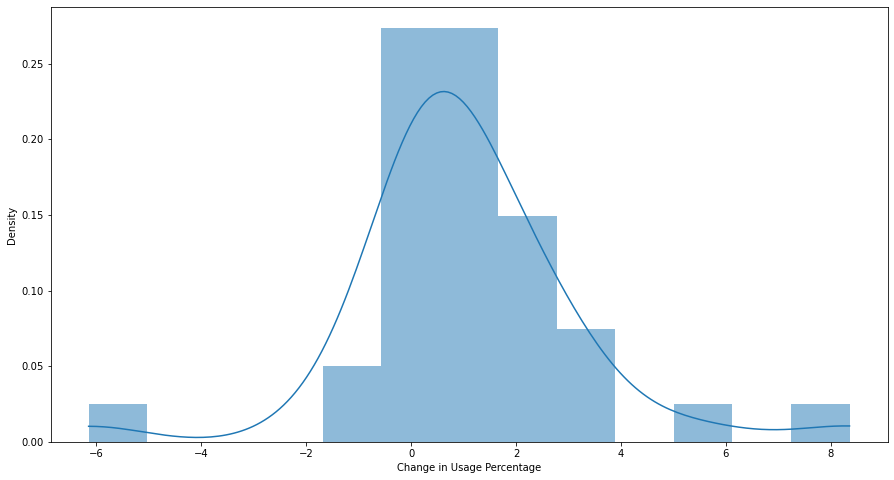

In [42]:
plt.figure(figsize=(15,8))
sns.histplot(x=df_final['change_pct'], kde=True, stat="density", linewidth=0).set(xlabel='Change in Usage Percentage')

Looking at the distribution for change in usage percentage of higher performing/newer GPUs, we can see that it is normal with a mean greater than 0 as well as some larger values in both the negative and positive directions. We can determine when these occur.

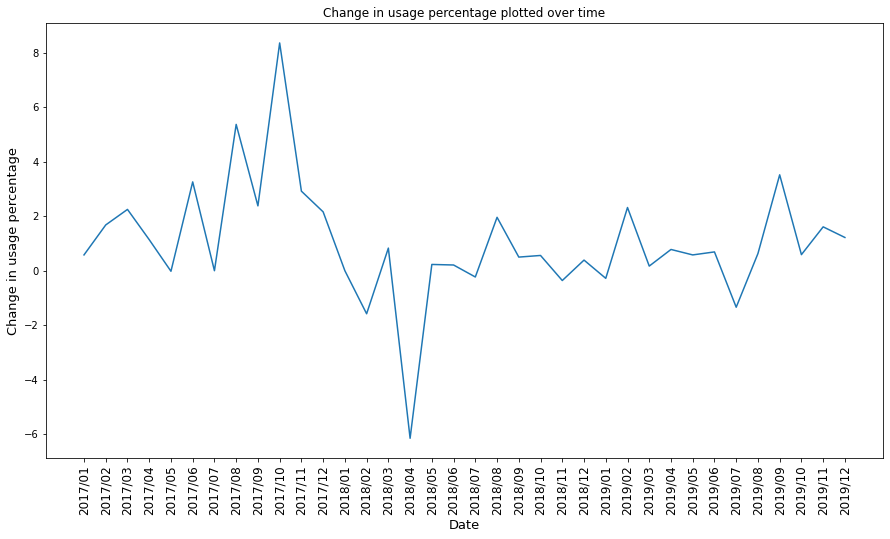

In [43]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='date', y='change_pct', data=df_final)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)
plt.title('Change in usage percentage plotted over time')
plt.xticks(fontsize=12, rotation=90)
plt.show()

We were able to identify where the large values from the distribution plot occurs, but more importantly, we can see that the change in usage percentage has periods of sudden increase and some periods show greater increase than others. Now that we know there exists periods where usage rate of higher performing/newer GPUs, we can begin to analyze if there's any correlation to our popular/demanding variables.

#### Looking for Patterns (Eyeball Test)

Lets see if any of the popularity variables show any similar patterns

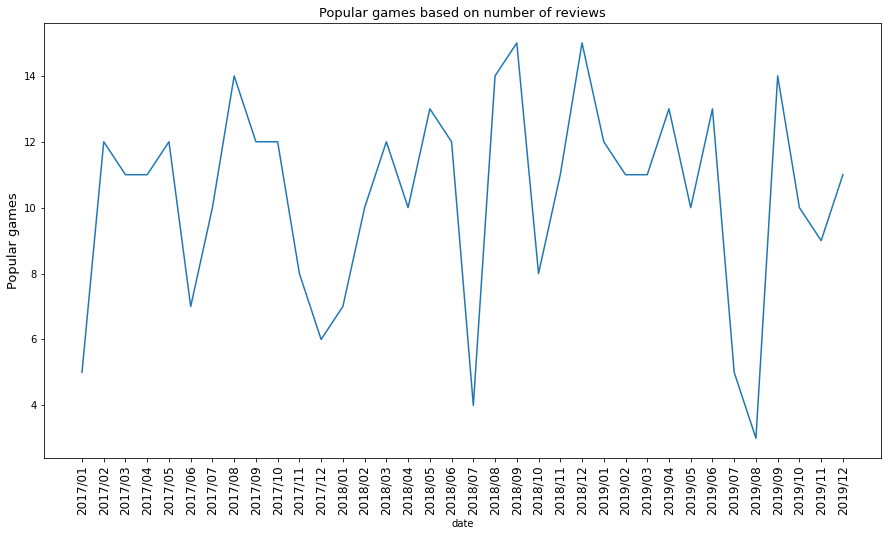

In [44]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='date', y='popular_revs', data=df_final)

plt.xticks(fontsize=12, rotation=90)
plt.title('Popular games based on number of reviews', fontsize = 13)
plt.ylabel('Popular games', fontsize = 13)
plt.show()

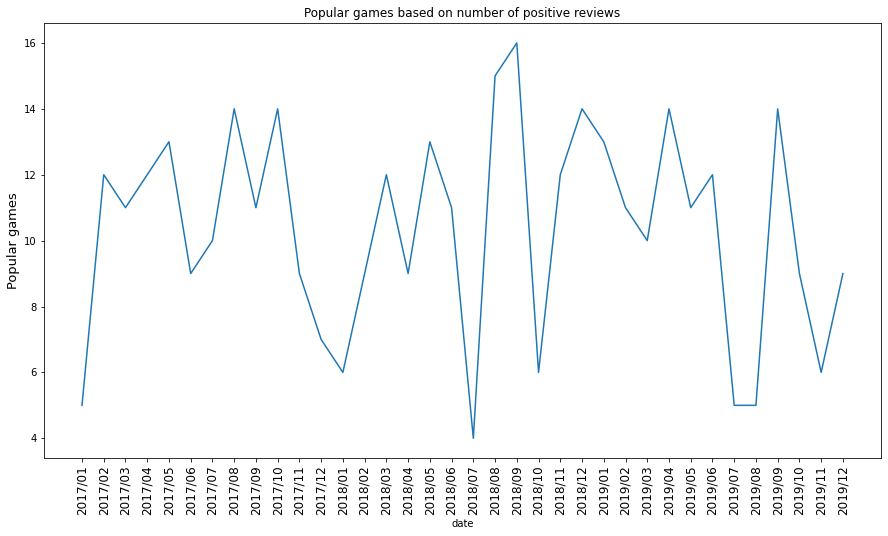

In [45]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='date', y='popular_pos_revs', data=df_final)
plt.ylabel('Popular games', fontsize = 13)
plt.title('Popular games based on number of positive reviews')
plt.xticks(fontsize=12, rotation=90)
plt.show()

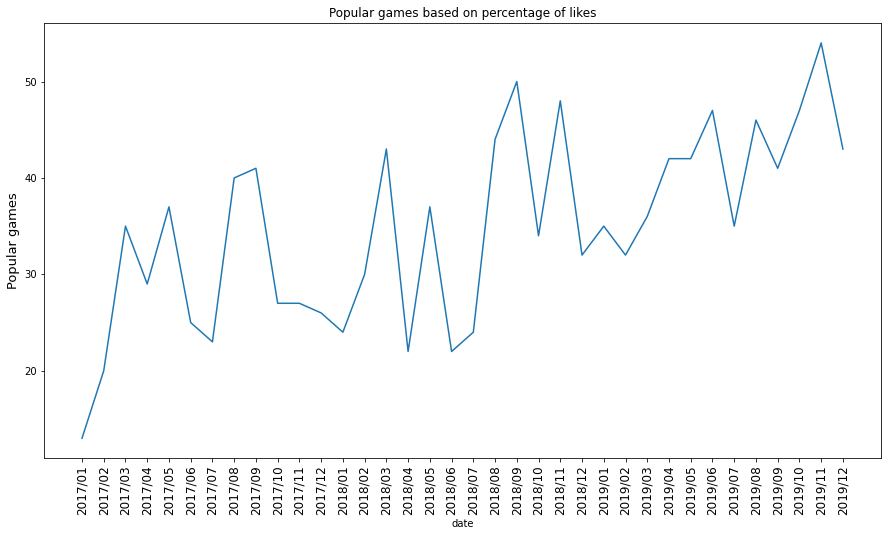

In [46]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='date', y='popular_pct_likes', data=df_final)
plt.title('Popular games based on percentage of likes')
plt.ylabel('Popular games', fontsize = 13)
plt.xticks(fontsize=12, rotation=90)
plt.show()

#### What do we find about the popularity graphs?

None of them show any significant patterns to the change in usage percentage graph.

There's a few small differences between the number of games with a popular number of reviews and the number of games with a popular number of positive reviews, but in general, they share a similar pattern. Their slope throughout the years looks to be horizontal, but it isn't entirely clear by simply looking at the graphs.

The graph for number of games with a popular percentage of likes has an upward sloping pattern.

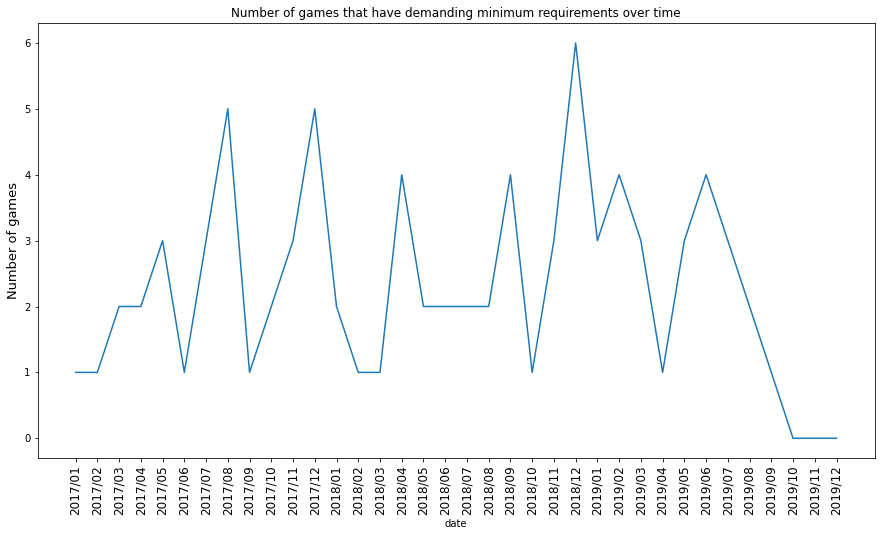

In [47]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='date', y='min_demanding', data=df_final)
plt.title('Number of games that have demanding minimum requirements over time')
plt.ylabel('Number of games', fontsize = 13)

plt.xticks(fontsize=12, rotation=90)
plt.show()

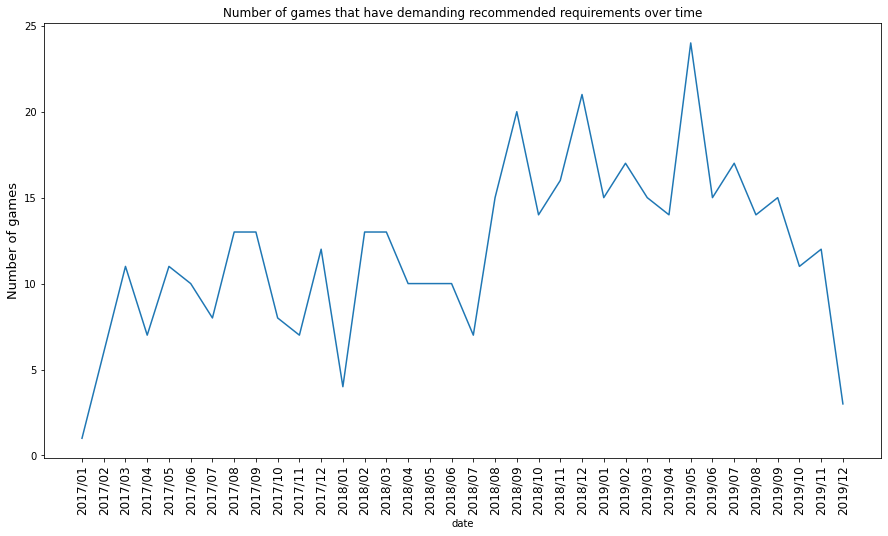

In [48]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='date', y='rec_demanding', data=df_final)
plt.title('Number of games that have demanding recommended requirements over time')
plt.ylabel('Number of games', fontsize = 13)

plt.xticks(fontsize=12, rotation=90)
plt.show()

#### What do we find about the demanding graphs?

There doesn't appear to be any significant patterns relating to change in usage percentage.

The graph for the number of games with a demanding minimum requirement looks to have a horizontal slope.

The slope of the graph for the number of games with a demanding recommended requirement looks to be positive, but it's not entirely clear since it begins to drop significantly in the later months.

### Linear Regression

Instead of simply looking for patterns, linear regression models can be used to look for correlations. We can start by plotting the graph to get a visual, then take a look at the Ordinary Least Squares (OLS) regression results for more details.

Text(0, 0.5, 'Change in usage percentage')

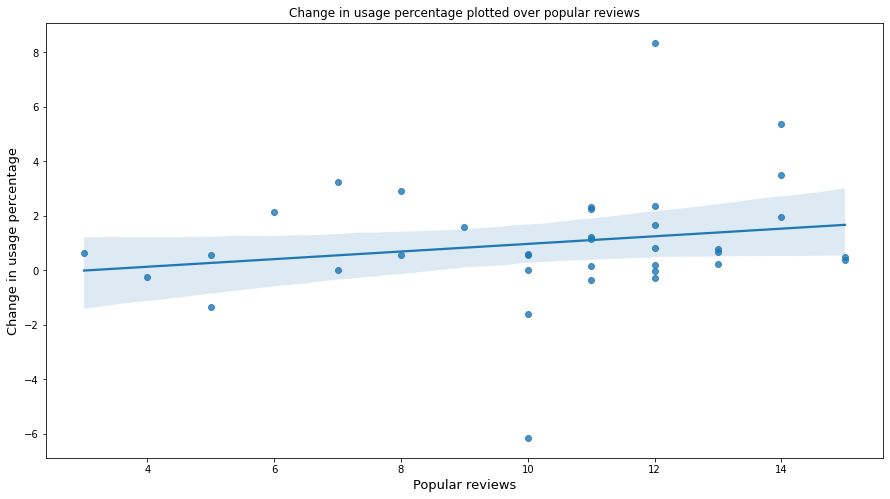

In [49]:
plt.figure(figsize=(15,8))
plt.title('Change in usage percentage plotted over popular reviews')

sns.regplot(x='popular_revs', y='change_pct', data=df_final)
plt.xlabel('Popular reviews', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)

In [50]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.337
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.256
Time:                        23:55:18   Log-Likelihood:                -78.499
No. Observations:                  36   AIC:                             161.0
Df Residuals:                      34   BIC:                             164.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.4226      1.305     -0.324      0.748      -3.075       2.230
popular_revs     0.1398      0.121      1.156      0.256      -0.106       0.385
==============================================================================
Omnibus:                       10.732   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               27.842
Skew:                           0.180   Prob(JB):                     9.00e-07
Kurtosis:                       7.293   Cond. No.                         38.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for popular_revs is 0.256 meaning that there is a %25.6 chance that popular_revs has no affect on change_pct (dependent variable). The relationship is not statistically significant (p > 0.05). R-squared is 0.038, which means that %3.8 of the variance in change_pct can be explained by our model

Text(0, 0.5, 'Change in usage percentage')

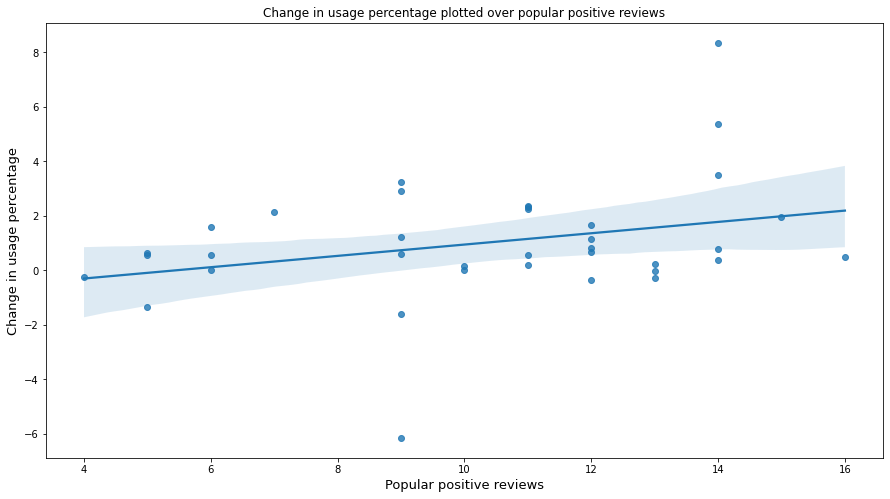

In [51]:
plt.figure(figsize=(15,8))
plt.title('Change in usage percentage plotted over popular positive reviews')

sns.regplot(x='popular_pos_revs', y='change_pct', data=df_final)
plt.xlabel('Popular positive reviews', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)

In [52]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_pos_revs', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.406
Date:                Fri, 10 Dec 2021   Prob (F-statistic):             0.0737
Time:                        23:55:19   Log-Likelihood:                -77.474
No. Observations:                  36   AIC:                             158.9
Df Residuals:                      34   BIC:                             162.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.1260      1.219     -0.923      0.362      -3.604       1.352
popular_pos_revs     0.2077      0.113      1.846      0.074      -0.021       0.436
==============================================================================
Omnibus:                        9.041   Durbin-Watson:                   1.474
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               19.551
Skew:                           0.018   Prob(JB):                     5.68e-05
Kurtosis:                       6.610   Cond. No.                         37.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for popular_pos_revs is 0.074 meaning that there is a %7.4 chance that popular_pos_revs has no affect on change_pct (dependent variable). So, the relationship is not statistically significant (p > 0.05). R-squared is 0.091, which means that %9.1 of the variance in change_pct can be explained by our model.

Text(0.5, 1.0, 'Change in usage percentage plotted over percentage of likes')

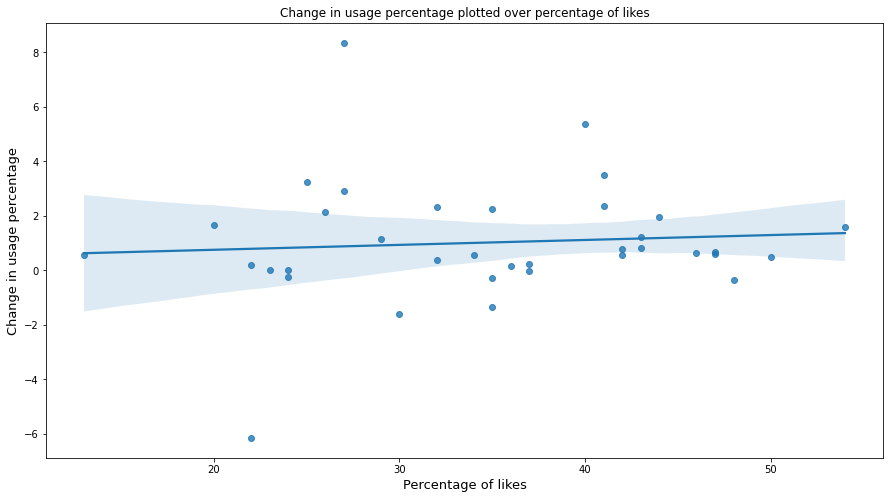

In [53]:
plt.figure(figsize=(15,8))
sns.regplot(x='popular_pct_likes', y='change_pct', data=df_final)
plt.xlabel('Percentage of likes', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)
plt.title('Change in usage percentage plotted over percentage of likes')

In [54]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_pct_likes', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.2195
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.642
Time:                        23:55:19   Log-Likelihood:                -79.077
No. Observations:                  36   AIC:                             162.2
Df Residuals:                      34   BIC:                             165.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3993      1.388      0.288      0.775      -2.422       3.221
popular_pct_likes     0.0180      0.038      0.469      0.642      -0.060       0.096
==============================================================================
Omnibus:                       12.082   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               29.875
Skew:                           0.437   Prob(JB):                     3.26e-07
Kurtosis:                       7.376   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for popular_pct_likes is 0.642 meaning that there is a %64.2 chance that popular_pct_likes has no affect on change_pct (dependent variable). Therefore, the relationship is not statistically significant (p > 0.05). R-squared is 0.006, which means that %0.6 of the variance in change_pct can be explained by our model. As we can see, effects of popular_pct_likes on our dependent variable is minimal.

Text(0.5, 1.0, 'Change in usage percentage plotted over # games that have demanding min requirements')

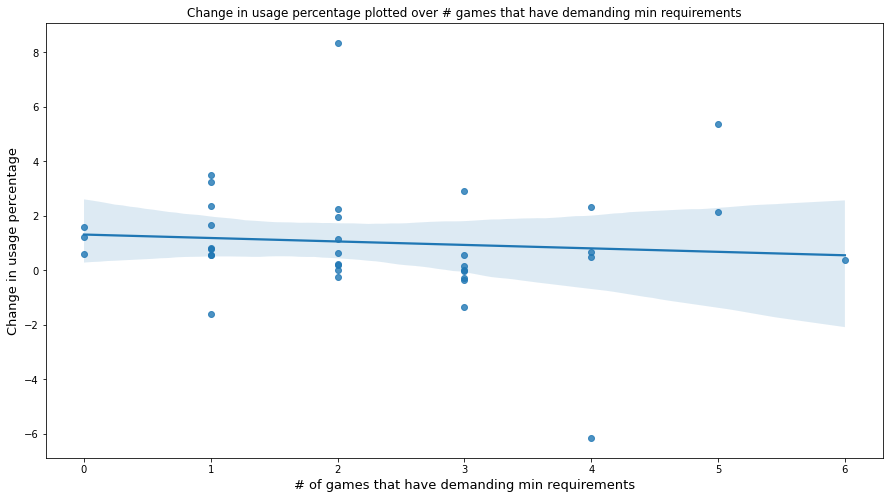

In [55]:
plt.figure(figsize=(15,8))
sns.regplot(x='min_demanding', y='change_pct', data=df_final)
plt.xlabel('# of games that have demanding min requirements', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)
plt.title('Change in usage percentage plotted over # games that have demanding min requirements')

In [56]:
outcome, predictors = patsy.dmatrices('change_pct ~ min_demanding', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.2428
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.625
Time:                        23:55:19   Log-Likelihood:                -79.065
No. Observations:                  36   AIC:                             162.1
Df Residuals:                      34   BIC:                             165.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.3183      0.701      1.881      0.069      -0.106       2.743
min_demanding    -0.1268      0.257     -0.493      0.625      -0.650       0.396
==============================================================================
Omnibus:                       11.593   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               27.933
Skew:                           0.402   Prob(JB):                     8.60e-07
Kurtosis:                       7.240   Cond. No.                         5.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for min_demanding is 0.625 meaning that there is a %62.5 chance that min_demanding has no affect on change_pct (dependent variable). The relationship is not statistically significant (p > 0.05). R-squared is 0.007, which means that %0.7 of the variance in change_pct can be explained by our model. Effect of min_demanding on our dependent variable is minimal

Text(0.5, 1.0, 'Change in usage percentage plotted over # games that have demanding recommended requirements')

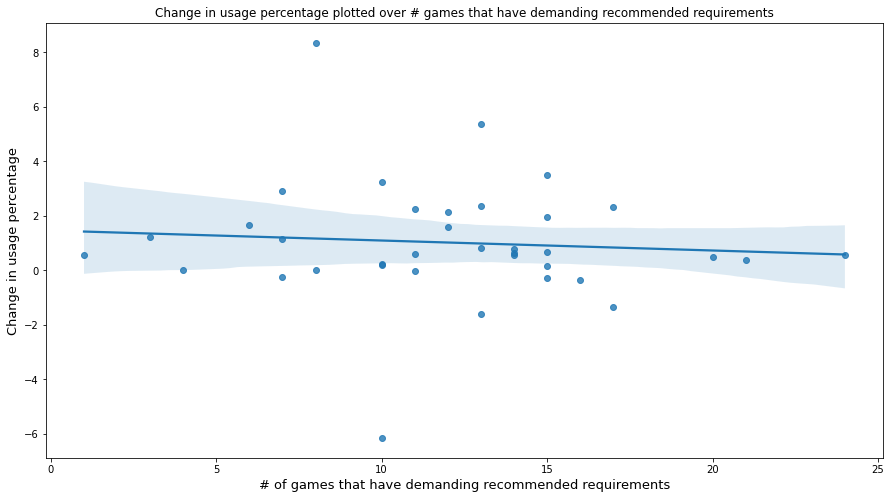

In [57]:
plt.figure(figsize=(15,8))
sns.regplot(x='rec_demanding', y='change_pct', data=df_final)
plt.xlabel('# of games that have demanding recommended requirements', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)
plt.title('Change in usage percentage plotted over # games that have demanding recommended requirements')

In [58]:
outcome, predictors = patsy.dmatrices('change_pct ~ rec_demanding', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.2256
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.638
Time:                        23:55:20   Log-Likelihood:                -79.074
No. Observations:                  36   AIC:                             162.1
Df Residuals:                      34   BIC:                             165.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4652      0.997      1.469      0.151      -0.562       3.492
rec_demanding    -0.0366      0.077     -0.475      0.638      -0.193       0.120
==============================================================================
Omnibus:                       11.014   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               29.253
Skew:                           0.205   Prob(JB):                     4.45e-07
Kurtosis:                       7.397   Cond. No.                         34.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for rec_demanding is 0.638 meaning that there is a %63.8 chance that rec_demanding has no affect on change_pct (dependent variable). The relationship is not statistically significant (p > 0.05). R-squared is 0.007, which means that %0.7 of the variance in change_pct can be explained by our model

#### Summary from Simple Linear Regression

Individually, none of them show correlation to change in usage percentage. The 95% confidence interval for all of our popularity variables and demanding variables contained 0. This can be seen in the summaries and in the shaded blue regions of the graphs.

One thing of note is the R-squared value for all models is relatively small.

## Multivariate Linear Regression

Although none of our dependent variables show correlation to the change in number of usage percentage individually, We can try to show correlation through the combination of multiple independent variables.

#### Popular Variables

#### Independent variables
- popular_revs
- popular_pct_likes

In [59]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + popular_pct_likes', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.6515
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.528
Time:                        23:55:20   Log-Likelihood:                -78.496
No. Observations:                  36   AIC:                             163.0
Df Residuals:                      33   BIC:                             167.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.4899      1.629     -0.301      0.765      -3.804       2.824
popular_revs          0.1365      0.131      1.041      0.306      -0.130       0.403
popular_pct_likes     0.0029      0.041      0.071      0.944      -0.081       0.086
==============================================================================
Omnibus:                       10.796   Durbin-Watson:                   1.519
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               27.762
Skew:                           0.209   Prob(JB):                     9.37e-07
Kurtosis:                       7.282   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of both of our independent variables are greater than 0.05. So, there is no statistically significant relationship between our independent variables and dependent variable. R-squared is 0.038, which means that %3.8 of the variance in change_pct can be explained by our model.

#### Independent variables
- popular_pct_likes
- popular_pos_revs

In [60]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_pos_revs + popular_pct_likes', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.656
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.206
Time:                        23:55:20   Log-Likelihood:                -77.472
No. Observations:                  36   AIC:                             160.9
Df Residuals:                      33   BIC:                             165.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.0580      1.583     -0.668      0.509      -4.279       2.163
popular_pos_revs      0.2102      0.120      1.754      0.089      -0.034       0.454
popular_pct_likes    -0.0027      0.039     -0.069      0.946      -0.082       0.077
==============================================================================
Omnibus:                        9.063   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               19.670
Skew:                          -0.007   Prob(JB):                     5.35e-05
Kurtosis:                       6.621   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of both of our independent variables are greater than 0.05. So, there is no statistically significant relationship between our independent variables and dependent variable. R-squared is 0.091, which means that %9.1 of the variance in change_pct can be explained by our model

#### Independent variables
- popular_revs
- popular_pos_revs

In [61]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + popular_pos_revs', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     2.866
Date:                Fri, 10 Dec 2021   Prob (F-statistic):             0.0712
Time:                        23:55:20   Log-Likelihood:                -76.310
No. Observations:                  36   AIC:                             158.6
Df Residuals:                      33   BIC:                             163.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5991      1.250     -0.479      0.635      -3.142       1.943
popular_revs        -0.4724      0.318     -1.485      0.147      -1.119       0.175
popular_pos_revs     0.6292      0.305      2.066      0.047       0.009       1.249
==============================================================================
Omnibus:                        6.712   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.035   Jarque-Bera (JB):               10.072
Skew:                          -0.087   Prob(JB):                      0.00650
Kurtosis:                       5.585   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here we can see that the p-value of popular_pos_revs is slightly lower than 0.05, which was not the case when we used a single variable regression. This might indicate that the affect of popular_pos_revs might be significant when used together with popular_revs. However, we still need further analysis to confirm that

#### Independent variables
- All popular variables

In [62]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + popular_pct_likes + popular_pos_revs', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     1.876
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.154
Time:                        23:55:20   Log-Likelihood:                -76.277
No. Observations:                  36   AIC:                             160.6
Df Residuals:                      32   BIC:                             166.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8203      1.563     -0.525      0.603      -4.005       2.364
popular_revs         -0.4891      0.330     -1.482      0.148      -1.161       0.183
popular_pct_likes     0.0095      0.039      0.242      0.810      -0.071       0.090
popular_pos_revs      0.6353      0.310      2.049      0.049       0.004       1.267
==============================================================================
Omnibus:                        6.397   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                9.229
Skew:                          -0.030   Prob(JB):                      0.00991
Kurtosis:                       5.480   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of our independent variables are greater than 0.05 (with one being ~ 0.05). So, there is no statistically significant relationship between our independent variables and dependent variable. R-squared is 0.150, which means that %1.5 of the variance in change_pct can be explained by our model

#### Demanding Variables

We find little point in using min_demanding and rec_demanding together as independent variables because if a game has a demanding minimum requirement, then it also has a demanding recommended requirement. However, it is only one linear regression model and including it will not take long.

NOTE: In the multivariate regressions with popular and demanding variables combined, we will separate min_demanding and rec_demanding. In other words, none of the models will contain both min_demanding and rec_demanding.

#### Independent Variables
- min_demanding
- rec_demanding

In [63]:
outcome, predictors = patsy.dmatrices('change_pct ~ min_demanding + rec_demanding', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.1576
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.855
Time:                        23:55:20   Log-Likelihood:                -79.022
No. Observations:                  36   AIC:                             164.0
Df Residuals:                      33   BIC:                             168.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5282      1.031      1.482      0.148      -0.570       3.626
min_demanding    -0.0902      0.292     -0.309      0.759      -0.684       0.503
rec_demanding    -0.0245      0.087     -0.281      0.781      -0.202       0.153
==============================================================================
Omnibus:                       11.170   Durbin-Watson:                   1.653
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.781
Skew:                           0.315   Prob(JB):                     9.28e-07
Kurtosis:                       7.257   Cond. No.                         36.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of our independent variables are significantly greater than 0.05. So, there is no statistically significant relationship between our independent variables and dependent variable.

#### Summary of Multivariate Regression while Popular and Demanding variables are separated

No correlation could be found while keeping popular and demanding variables separate.

It doesn't seem that popularity of a video game nor demanding games correlates to change in usage percentage individually. However, popular and demanding video games may show a correlation to change in usage percentage.

#### min_demanding and Popular variables

##### Independent variables
- popular_revs
- min_demanding

In [64]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + min_demanding', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9242
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.407
Time:                        23:55:21   Log-Likelihood:                -78.212
No. Observations:                  36   AIC:                             162.4
Df Residuals:                      33   BIC:                             167.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1636      1.362     -0.120      0.905      -2.934       2.607
popular_revs      0.1569      0.124      1.265      0.215      -0.095       0.409
min_demanding    -0.1891      0.260     -0.728      0.472      -0.718       0.340
==============================================================================
Omnibus:                       10.750   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               24.195
Skew:                           0.358   Prob(JB):                     5.57e-06
Kurtosis:                       6.952   Cond. No.                         41.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of our independent variables are greater than 0.05. So, there is no statistically significant relationship between our independent variables and dependent variable. R-squared is 0.053, which means that %5.3 of the variance in change_pct can be explained by our model

##### Independent variables
- popular_pct_likes
- min_demanding

In [65]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_pct_likes + min_demanding', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.048
Method:                 Least Squares   F-statistic:                    0.2058
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.815
Time:                        23:55:21   Log-Likelihood:                -78.970
No. Observations:                  36   AIC:                             163.9
Df Residuals:                      33   BIC:                             168.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.7256      1.585      0.458      0.650      -2.500       3.951
popular_pct_likes     0.0163      0.039      0.418      0.679      -0.063       0.096
min_demanding        -0.1163      0.262     -0.444      0.660      -0.649       0.416
==============================================================================
Omnibus:                       12.378   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.321
Skew:                           0.530   Prob(JB):                     7.08e-07
Kurtosis:                       7.214   Cond. No.                         153.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of our independent variables are greater than 0.05. So, there is no statistically significant relationship between our independent variables and dependent variable. R-squared is 0.012, which means that %1.2 of the variance in change_pct can be explained by our model

##### Independent variables
- popular_pos_revs
- min_demanding

In [66]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_pos_revs + min_demanding', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.254
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.121
Time:                        23:55:21   Log-Likelihood:                -76.889
No. Observations:                  36   AIC:                             159.8
Df Residuals:                      33   BIC:                             164.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.8470      1.247     -0.679      0.502      -3.383       1.689
popular_pos_revs     0.2401      0.117      2.059      0.047       0.003       0.477
min_demanding       -0.2666      0.255     -1.045      0.304      -0.786       0.253
==============================================================================
Omnibus:                        8.334   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               14.541
Skew:                           0.258   Prob(JB):                     0.000696
Kurtosis:                       6.070   Cond. No.                         39.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-value for popular_pos_revs is barely lower than 0.05. So, we might say that there is probably no significant relationship between our variables. R-squared is 0.120, which means that %12 of the variance in change_pct can be explained by our model

##### Independent variables
- popular_revs
- popular_pct_likes
- min_demanding

In [67]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + min_demanding + popular_pct_likes', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.5986
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.621
Time:                        23:55:21   Log-Likelihood:                -78.210
No. Observations:                  36   AIC:                             164.4
Df Residuals:                      32   BIC:                             170.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1037      1.727     -0.060      0.952      -3.622       3.415
popular_revs          0.1599      0.136      1.175      0.249      -0.117       0.437
min_demanding        -0.1919      0.268     -0.716      0.479      -0.738       0.354
popular_pct_likes    -0.0024      0.042     -0.058      0.954      -0.088       0.083
==============================================================================
Omnibus:                       10.646   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               24.128
Skew:                           0.337   Prob(JB):                     5.76e-06
Kurtosis:                       6.954   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of our independent variables are greater than 0.05. So, there is no statistically significant relationship between our independent variables and dependent variable. R-squared is 0.053, which means that %5.3 of the variance in change_pct can be explained by our model

##### Independent variables
- popular_pos_revs
- popular_pct_likes
- min_demanding

In [68]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_pos_revs + min_demanding + popular_pct_likes', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.485
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.237
Time:                        23:55:21   Log-Likelihood:                -76.847
No. Observations:                  36   AIC:                             161.7
Df Residuals:                      32   BIC:                             168.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5596      1.648     -0.340      0.736      -3.917       2.798
popular_pos_revs      0.2517      0.126      2.001      0.054      -0.004       0.508
min_demanding        -0.2804      0.264     -1.063      0.296      -0.818       0.257
popular_pct_likes    -0.0108      0.040     -0.272      0.787      -0.092       0.070
==============================================================================
Omnibus:                        8.054   Durbin-Watson:                   1.480
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               14.346
Skew:                           0.171   Prob(JB):                     0.000767
Kurtosis:                       6.074   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of our independent variables are greater than 0.05. So, there is no statistically significant relationship between our independent variables and dependent variable. R-squared is 0.122, which means that %12.2 of the variance in change_pct can be explained by our model

##### Independent variables
- popular_revs
- popular_pos_revs
- min_demanding

In [69]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + min_demanding + popular_pos_revs', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     2.560
Date:                Fri, 10 Dec 2021   Prob (F-statistic):             0.0723
Time:                        23:55:21   Log-Likelihood:                -75.321
No. Observations:                  36   AIC:                             158.6
Df Residuals:                      32   BIC:                             165.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1654      1.276     -0.130      0.898      -2.765       2.434
popular_revs        -0.5439      0.319     -1.707      0.098      -1.193       0.105
min_demanding       -0.3382      0.252     -1.344      0.188      -0.851       0.174
popular_pos_revs     0.7341      0.311      2.361      0.024       0.101       1.367
==============================================================================
Omnibus:                        5.270   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.837
Skew:                           0.184   Prob(JB):                       0.0540
Kurtosis:                       4.938   Cond. No.                         57.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for popular_pos_revs is below 0.05, which was not the case when we used single variable linear regression. This could mean that popular_pos_revs might have a significant affect on our dependent variable in this given context.

##### Independent variables
- All popular variables
- min_demanding

In [70]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + min_demanding + popular_pos_revs + popular_pct_likes', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1.860
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.142
Time:                        23:55:21   Log-Likelihood:                -75.320
No. Observations:                  36   AIC:                             160.6
Df Residuals:                      31   BIC:                             168.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1937      1.620     -0.120      0.906      -3.498       3.111
popular_revs         -0.5456      0.329     -1.657      0.108      -1.217       0.126
min_demanding        -0.3370      0.259     -1.301      0.203      -0.865       0.191
popular_pos_revs      0.7345      0.316      2.324      0.027       0.090       1.379
popular_pct_likes     0.0011      0.039      0.029      0.977      -0.079       0.082
==============================================================================
Omnibus:                        5.264   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.803
Skew:                           0.189   Prob(JB):                       0.0549
Kurtosis:                       4.930   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again, the p-value of popular_pos_revs is below 0.05. We might infer that popular_pos_revs have a significant impact when used in this given context. Also, the value R-squared went up compared to other results, which can mean that we can explain more of the variance by this set of independent variables

#### rec_demanding and Popular variables

##### Independent variables
- popular_revs
- rec_demanding

In [71]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + rec_demanding', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.113
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.341
Time:                        23:55:22   Log-Likelihood:                -78.018
No. Observations:                  36   AIC:                             162.0
Df Residuals:                      33   BIC:                             166.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0548      1.402      0.039      0.969      -2.797       2.906
popular_revs      0.1824      0.129      1.412      0.167      -0.080       0.445
rec_demanding    -0.0766      0.081     -0.945      0.352      -0.242       0.088
==============================================================================
Omnibus:                       10.382   Durbin-Watson:                   1.601
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               27.021
Skew:                          -0.023   Prob(JB):                     1.36e-06
Kurtosis:                       7.244   Cond. No.                         63.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of our independent variables are greater than 0.05. So, there is no statistically significant relationship between our independent variables and dependent variable. R-squared is 0.063, which means that %6.3 of the variance in change_pct can be explained by our model

##### Independent variables
- popular_pct_likes
- rec_demanding

In [72]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_pct_likes + rec_demanding', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.5059
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.608
Time:                        23:55:22   Log-Likelihood:                -78.649
No. Observations:                  36   AIC:                             163.3
Df Residuals:                      33   BIC:                             168.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.5857      1.408      0.416      0.680      -2.279       3.451
popular_pct_likes     0.0414      0.047      0.887      0.381      -0.053       0.136
rec_demanding        -0.0833      0.094     -0.891      0.379      -0.274       0.107
==============================================================================
Omnibus:                       11.804   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               27.263
Skew:                           0.462   Prob(JB):                     1.20e-06
Kurtosis:                       7.162   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of our independent variables are greater than 0.05. So, there is no statistically significant relationship between our independent variables and dependent variable. R-squared is 0.030, which means that %3.0 of the variance in change_pct can be explained by our model

##### Independent variables
- popular_pos_revs
- rec_demanding

In [73]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_pos_revs + rec_demanding', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     2.580
Date:                Fri, 10 Dec 2021   Prob (F-statistic):             0.0910
Time:                        23:55:22   Log-Likelihood:                -76.578
No. Observations:                  36   AIC:                             159.2
Df Residuals:                      33   BIC:                             163.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5071      1.298     -0.391      0.699      -3.148       2.134
popular_pos_revs     0.2664      0.120      2.215      0.034       0.022       0.511
rec_demanding       -0.1023      0.079     -1.298      0.203      -0.263       0.058
==============================================================================
Omnibus:                        9.387   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               18.970
Skew:                          -0.268   Prob(JB):                     7.60e-05
Kurtosis:                       6.516   Cond. No.                         61.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value of popular_pos_revs is below 0.05. So, the effect of this independent variable could be significant in this given context. We can also see that the value of R-squared went up compared to other results.

##### Independent variables
- popular_revs
- popular_pct_likes
- rec_demanding

In [74]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + rec_demanding + popular_pct_likes', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.8581
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.473
Time:                        23:55:22   Log-Likelihood:                -77.800
No. Observations:                  36   AIC:                             163.6
Df Residuals:                      32   BIC:                             169.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.4418      1.623     -0.272      0.787      -3.748       2.864
popular_revs          0.1656      0.133      1.243      0.223      -0.106       0.437
rec_demanding        -0.1062      0.095     -1.123      0.270      -0.299       0.086
popular_pct_likes     0.0295      0.047      0.625      0.537      -0.067       0.126
==============================================================================
Omnibus:                       10.242   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.665
Skew:                           0.193   Prob(JB):                     4.41e-06
Kurtosis:                       7.037   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-values of our independent variables are greater than 0.05. So, there is no statistically significant relationship between our independent variables and dependent variable. R-squared is 0.074, which means that %7.4 of the variance in change_pct can be explained by our model

##### Independent variables:
- popular_pos_revs
- popular_pct_likes
- rec_demanding

In [75]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_pos_revs + rec_demanding + popular_pct_likes', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.846
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.159
Time:                        23:55:22   Log-Likelihood:                -76.320
No. Observations:                  36   AIC:                             160.6
Df Residuals:                      32   BIC:                             167.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.0803      1.557     -0.694      0.493      -4.252       2.092
popular_pos_revs      0.2567      0.122      2.102      0.043       0.008       0.505
rec_demanding        -0.1341      0.092     -1.454      0.156      -0.322       0.054
popular_pct_likes     0.0304      0.045      0.679      0.502      -0.061       0.121
==============================================================================
Omnibus:                        8.261   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               15.840
Skew:                          -0.069   Prob(JB):                     0.000363
Kurtosis:                       6.247   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value of popular_pos_revs is slighyly under 0.05, which is a recurring pattern so far in our analysis.

##### Independent variables
- popular_revs
- popular_pos_revs
- rec_demanding

In [76]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + rec_demanding + popular_pos_revs', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     2.543
Date:                Fri, 10 Dec 2021   Prob (F-statistic):             0.0736
Time:                        23:55:23   Log-Likelihood:                -75.344
No. Observations:                  36   AIC:                             158.7
Df Residuals:                      32   BIC:                             165.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0237      1.322      0.018      0.986      -2.668       2.716
popular_revs        -0.4738      0.314     -1.507      0.142      -1.114       0.167
rec_demanding       -0.1027      0.077     -1.328      0.194      -0.260       0.055
popular_pos_revs     0.6894      0.305      2.264      0.030       0.069       1.310
==============================================================================
Omnibus:                        7.670   Durbin-Watson:                   1.634
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               11.342
Skew:                          -0.323   Prob(JB):                      0.00344
Kurtosis:                       5.673   Cond. No.                         75.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value of popular_pos_revs is lower than 0.05, which can mean that it's effects might be significant. We need further analysis.

##### Independent variables
- All popular variables
- rec_demanding

In [77]:
outcome, predictors = patsy.dmatrices('change_pct ~ popular_revs + rec_demanding + popular_pos_revs + popular_pct_likes', df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     2.226
Date:                Fri, 10 Dec 2021   Prob (F-statistic):             0.0891
Time:                        23:55:23   Log-Likelihood:                -74.649
No. Observations:                  36   AIC:                             159.3
Df Residuals:                      31   BIC:                             167.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8109      1.518     -0.534      0.597      -3.907       2.286
popular_revs         -0.5614      0.323     -1.737      0.092      -1.221       0.098
rec_demanding        -0.1546      0.090     -1.713      0.097      -0.339       0.029
popular_pos_revs      0.7518      0.309      2.435      0.021       0.122       1.381
popular_pct_likes     0.0494      0.045      1.105      0.278      -0.042       0.141
==============================================================================
Omnibus:                        5.217   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                5.936
Skew:                          -0.123   Prob(JB):                       0.0514
Kurtosis:                       4.974   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value of popular_pos_revs is lower than 0.05, and our R-squared is 0.223, which might mean that we are onto something. We are going to further analyze these variables using variance inflation factor

#### Summary of Multivariate Regressions while Popular and Demanding variables were combined

Above we have 14 different combinations of popular and demanding variables. These are the correlations we were able to find:

#### min_demanding and Popular variables Summary

##### Independent variables
- popular_revs
- popular_pos_revs
- min_demanding

When using popular_revs and popular_pos_revs only, we get a correlation for popular_pos_revs with a slope of 0.7341 and an R-square value of 0.194.

##### Independent variables
- All popular variables
- min_demanding

When using all popular variables, we get a correlation for popular_pos_revs with a slope of 0.7345 and an R-square value of 0.194.

While using these two combinations of variables, we were able to find a correlation between change in usage percentage and number of games with popular number of positive reviews.

#### rec_demanding and Popular variables Summary

##### Independent variables
- popular_pos_revs
- rec_demanding

When using popular_pos_revs only, we get a correlation for popular_pos_revs with a slope of 0.2664, R-squared value of 0.135

##### Independent variables
- popular_revs
- popular_pos_revs
- rec_demanding

When using popular_revs and popular_pos_revs only, we get a correlation for popular_pos_revs with a slope of 0.6894, R-squared value of 0.193

##### Independent variables
- All popular variables
- rec_demanding

When using all popular variables, we get a correlation for popular pos_revs with a slope of 0.7518, R-squared value of 0.223

While using these three combinations of variables, we were able to find a correlation between change in usage percentage and number of games with popular number of positive reviews.

#### Summary of Multivariate Regression

We weren't able to find any correlations when keeping popular and demanding variables separate, however, when combining these two, we were able to find a correlation. Specifically with the number of games with popular number of positive reviews. 

In multiple regression models with combined popular and demanding variables, we were able to find a slight positive correlation between change in usage percentage and number of games with popular number of positive reviews. 

## Is the correlation significant?

In the multivariate regression, we found correlation for four models. One concern is that our independent variables are collinear and to check for collinearity, we looked at variance inflation factor (VIF). The higher the VIF of an independent variable, the more correlated it is with the other independent variables. It's common that a VIF > 10 is an indicator of multicollinearity and so we will use that as our threshold.

We can check the VIF of the four models that gave us a correlation.

Independent variables:
- popular_revs
- popular_pos_revs
- min_demanding

In [78]:
vif = pd.DataFrame()
var = df_final[['popular_revs', 'popular_pos_revs', 'min_demanding']]
vif['variables'] = var.columns
vif['VIF'] = [variance_inflation_factor(var.values, i) for i in range(len(var.columns))]
vif

,variables,VIF
0,popular_revs,88.909308
1,popular_pos_revs,94.463866
2,min_demanding,3.657769


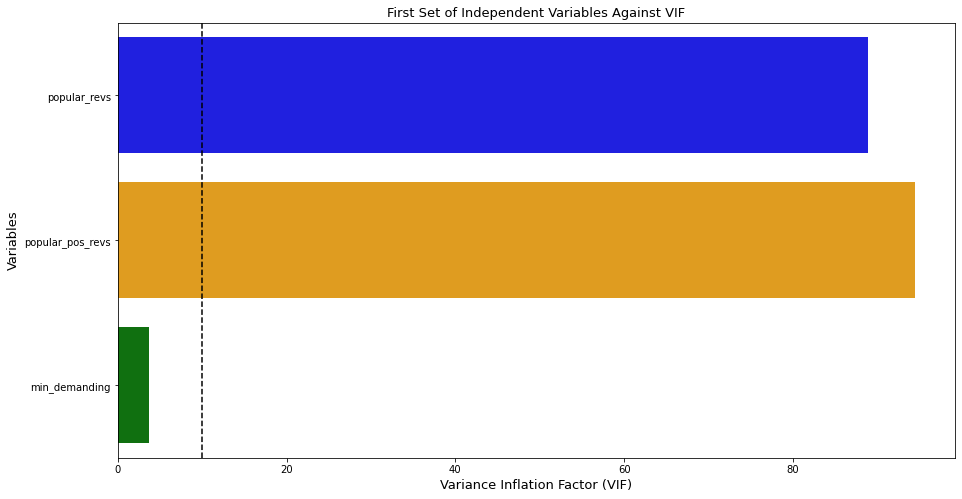

In [79]:
plt.figure(figsize=(15,8))
graph = sns.barplot(x='VIF', y='variables', data=vif, palette= ['blue', 'orange', 'green'])
graph.axvline(10, c = 'k', linestyle = '--')

plt.xlabel('Variance Inflation Factor (VIF)', fontsize = 13)
plt.ylabel('Variables', fontsize = 13)
plt.title('First Set of Independent Variables Against VIF', fontsize = 13)
plt.show()

VIF for popular variables are too high! These values are way beyond the acceptable VIF values. 

Independent variables:
- All popular variables
- min_demanding

In [80]:
vif = pd.DataFrame()
var = df_final[['popular_revs', 'popular_pos_revs', 'min_demanding', 'popular_pct_likes']]
vif['variables'] = var.columns
vif['VIF'] = [variance_inflation_factor(var.values, i) for i in range(len(var.columns))]
vif

,variables,VIF
0,popular_revs,100.091775
1,popular_pos_revs,94.554075
2,min_demanding,3.659232
3,popular_pct_likes,10.472384


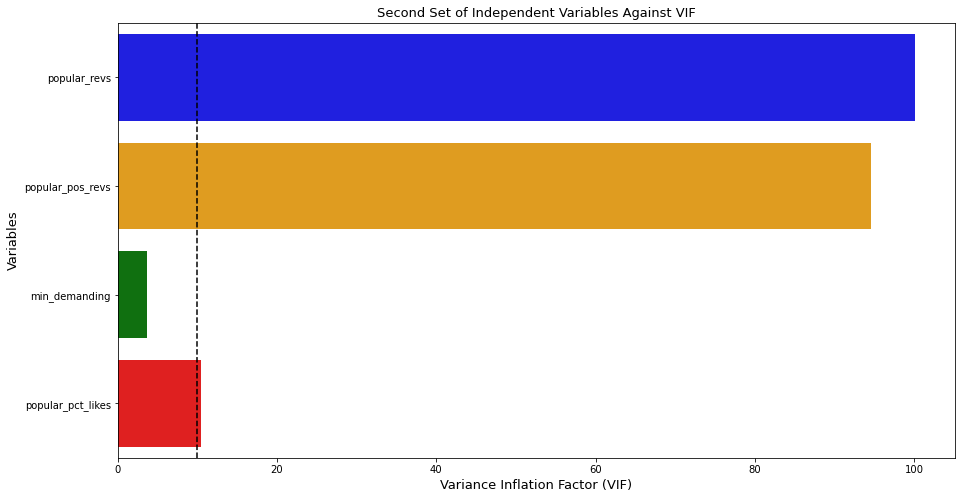

In [81]:
plt.figure(figsize=(15,8))

graph = sns.barplot(x='VIF', y='variables', data=vif, palette = ['blue', 'orange', 'green', 'red'])
graph.axvline(10, c = 'k', linestyle = '--')

plt.xlabel('Variance Inflation Factor (VIF)', fontsize = 13)
plt.ylabel('Variables', fontsize = 13)
plt.title('Second Set of Independent Variables Against VIF', fontsize = 13)
plt.show()

Popular variables too high!

##### Independent variables:
- popular_revs
- popular_pos_revs
- rec_demanding

In [82]:
vif = pd.DataFrame()
var = df_final[['popular_revs', 'popular_pos_revs', 'rec_demanding']]
vif['variables'] = var.columns
vif['VIF'] = [variance_inflation_factor(var.values, i) for i in range(len(var.columns))]
vif

,variables,VIF
0,popular_revs,89.009600
1,popular_pos_revs,90.509127
2,rec_demanding,7.271300


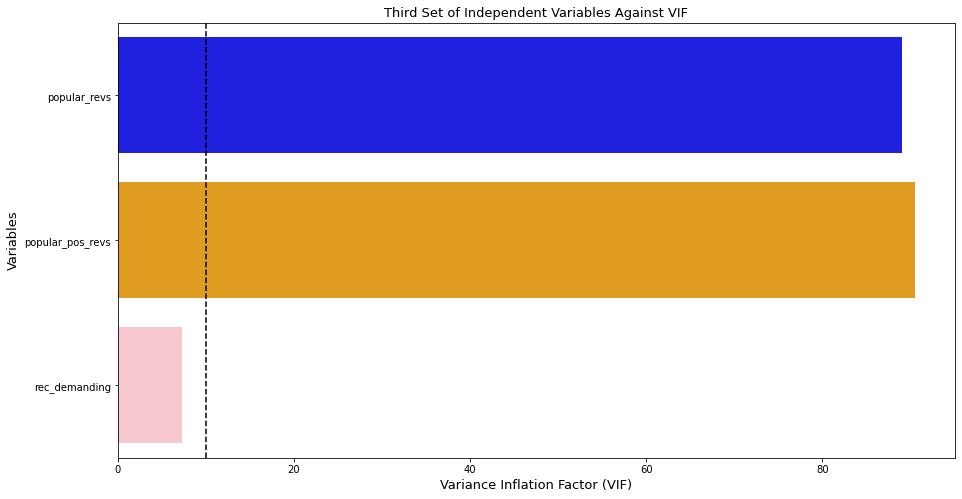

In [83]:
plt.figure(figsize=(15,8))

graph = sns.barplot(x='VIF', y='variables', data=vif, palette = ['blue', 'orange', 'pink'])
graph.axvline(10, c = 'k', linestyle = '--')

plt.xlabel('Variance Inflation Factor (VIF)', fontsize = 13)
plt.ylabel('Variables', fontsize = 13)
plt.title('Third Set of Independent Variables Against VIF', fontsize = 13)
plt.show()

Popular variables too high!

#### Independent variables:
- popular_pos_revs
- rec_demanding

In [84]:
vif = pd.DataFrame()
var = df_final[['popular_pos_revs', 'rec_demanding']]
vif['variables'] = var.columns
vif['VIF'] = [variance_inflation_factor(var.values, i) for i in range(len(var.columns))]
vif

,variables,VIF
0,popular_pos_revs,7.196824
1,rec_demanding,7.196824


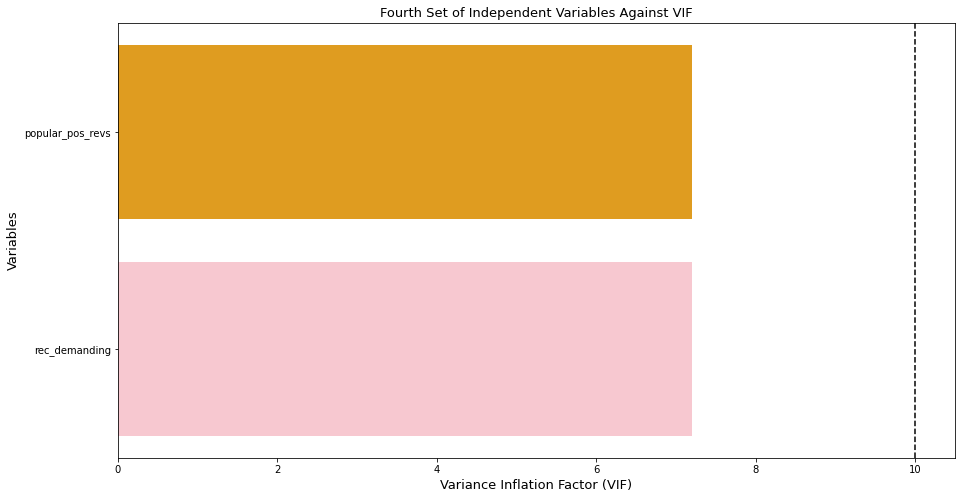

In [85]:
plt.figure(figsize=(15,8))

graph = sns.barplot(x='VIF', y='variables', data=vif, palette = ['orange', 'pink'])
graph.axvline(10, c= 'k', linestyle = '--')

plt.xlabel('Variance Inflation Factor (VIF)', fontsize = 13)
plt.ylabel('Variables', fontsize = 13)
plt.title('Fourth Set of Independent Variables Against VIF', fontsize = 13)
plt.show()

Passed the VIF test! VIF values are still relatively high.

#### Independent variables:
- All popular variables
- rec_demanding

In [86]:
vif = pd.DataFrame()
var = df_final[['popular_revs', 'popular_pos_revs', 'popular_pct_likes', 'rec_demanding']]
vif['variables'] = var.columns
vif['VIF'] = [variance_inflation_factor(var.values, i) for i in range(len(var.columns))]
vif

,variables,VIF
0,popular_revs,100.883778
1,popular_pos_revs,92.716103
2,popular_pct_likes,16.437015
3,rec_demanding,11.417294


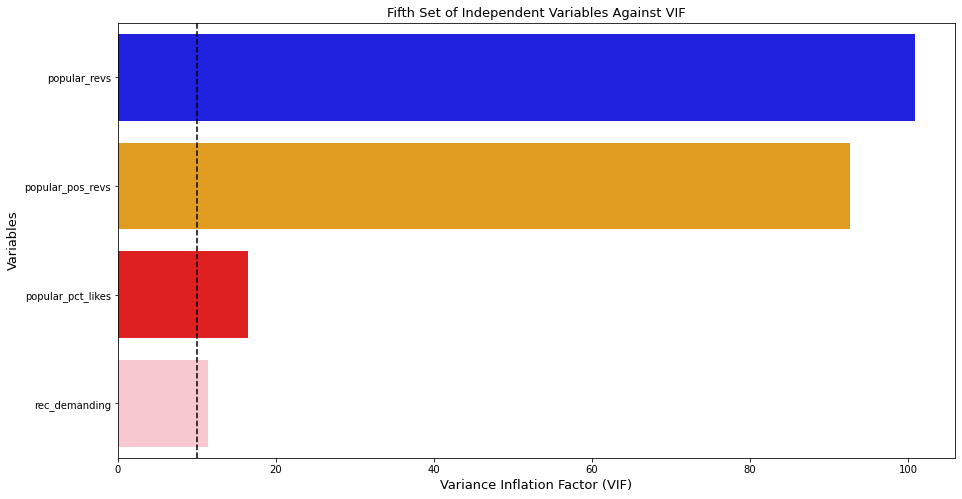

In [87]:
plt.figure(figsize=(15,8))

graph = sns.barplot(x='VIF', y='variables', data=vif, palette = ['blue', 'orange', 'red', 'pink'])
graph.axvline(10, c= 'k', linestyle = '--')

plt.xlabel('Variance Inflation Factor (VIF)', fontsize = 13)
plt.ylabel('Variables', fontsize = 13)
plt.title('Fifth Set of Independent Variables Against VIF', fontsize = 13)
plt.show()

All variables too high!

#### Variance Inflation Factor Results

Checking VIF values for the four models that showed correlation indicates collinearity issue for all four multivariate regression models. 

##### Popular Variables

The VIF for the popular variables in all four models are too high! 

##### Demanding Variables

The VIF for min_demanding is within acceptable range for both models.
The VIF for rec_demanding is relatively high in both models. It exceeds the threshold in the model with all popular variables.

#### Variance Inflation Factor Summary

From these results, it's highly probable that the correlations seen in the multivarite regression models are a result of collinearity and are not significant.

# Ethics & Privacy

The data sets we used are publicly available through the steam hardware and software website. Althought steam only give us the latest data, we were able to capture previous survey data by accessing wayback machine. Wayback machine is an initiative of the Internet Archive under 501(c)(3). Wayback machine and the no person can alter it once it have been captured. Steam is the largest digital distribution platfrom for PC gaming. Steam collect its user hardware and calculate the change compare to previous month.  

Regarding privacy, the datasets we used do not contain sensitive personal information and therefore do not infringe on any person’s privacy. User are chosen randomly and require the user consent before practicipe. All of the data are keep anonymous and will not be associate to the user steam account.  

Some biases that could be present in our analysis would come from the usere who are practiciping. Since most user who are on steam are aroung 20's, they are more likely to buy a new hardware once a while.

Another bias is using the popular variables we decided to go with. Popular has many definitions such as anticipation/pre-order buys, largest player base, and more. We beleived anticipation/pre-order could have been a better measurement of popularity in this case. However, when deciding for popularity variable measures, we chose variables that are easier to attain. We decided to do this because of two reasons. Firstly, we believe our variables can still give us a good measurement on GPU sales, just not as good as anticipation/pre-order buys and secondly, we are unsure if enough information on anticipation/pre-order buys was attainable since games on "Steam" don't have pre-order. 

# Conclusion & Discussion

#### Conclusion:
GPUs can be used for many reasons, such as machine learning or video editing to name a couple, but GPUs are also utilized to play video games. Many video games contain graphics that require the use of GPUs to render. Since GPUs and video games have this relation to them, we hypothesized that the release of a popular, demanding video game is positively correlated to an increase in GPU sales. 

In an attempt to find the effect of popular and demanding games on GPU sales, we took a look at "Steam", the largest online market for PC video games. Web scraping "Steam" yielded several measures on popularity of a game and how demanding a game is, as well as the change in usage percentages of GPUs per month, which became our measure for GPU sales.

We began by performing an eyeball test to look for any noticeable patterns between our popular or demanding measures with the change in usage percentages. Each variable was plotted on separate line graphs to show patterns over time. Results showed that two of the popular variables, games with a popular number of reviews and games with a popular number of positive reviews, had almost identical patterns, but no other noticeable patterns.

Unable to find anything relating our popular and demanding variables to the variable of interest from the eyeball test, we turned to simple linear regression. Results from all simple linear models contained 0 in their 95% confidence interval which means no correlation could be found.

Still with no correlation found, we tried using multivariate regression. Our multivariate regression models found correlation for five models. To test whether the correlations were actually significant, VIF tests were performed on each model and four models that showed correlation were determined to be insignificant. The VIF tests for each of these four OLS regression models showed severe collinearity in popular variables for all four models. In addition to this, the VIF values for games with demanding recommended requirements were high in both models it was tested in, which could indicate that there's correlation between games with demanding recommended requirements and popularity. The one model that didn't fail the VIF test still had high VIF values.

From the result of the analysis, one correlation could be found between popular and demanding video games on GPU sales. The release of a video game that achieves a popular positive review correlates with GPU sales.

#### Limitations:
We were able to find a correlation in our analysis, but this may have been due to some data limitations. One such limitation comes from our games dataset. Originally, the games dataset had over 80000 entries, but only 1493 of them went into the constructing the final dataset. In comparison, 24132 games were released on "Steam" over the 3 year interval this analysis was restricted to[7]. Since the values for the independent variables are counts of video games, the amount of games that go into the analysis can have substantial impact on the independent variables. In addition to this, the games dataset only considers "Steam" games which means console video games are not included. Consoles also make up a considerable portion of video games and the exclusion of console video games also directly impact the independent variables. 

Another limitation comes from our measure of variables. We were unable to attain GPU sales numbers and as a substitute, used the change in usage percentage of GPUs. A problem with this is we're only able to make correlation claims about popular, demanding games and change in usage percentage and from this, and therefore, the results of this analysis is only one possible indication to GPU sales. For popularity, a measurement that we considered, but also could not find the data for is the anticipation of a video game.

#### Discussion:
Our analysis found one correlation between popular and demanding games with GPU sales which could indicate that the demand for accelerated 3D rendering has not diminished over time. However, from the VIF tests, there is potentially a correlation between popularity and the demand of a video game. If a correlation can be found with GPU sales and popularity, then it's possible that popularity of video games could be a mediator variable between the graphical demand of video games and GPU sales. More analysis is needed in order to say there's a correlation for certain.

# Team Contributions

Each team member was assigned a specific portion of the report to write:


- Cameron VanderTuig: Background & Prior Work, Hypothesis, Dataset(s), Setup, Double Checking, Video
- Erdogan Ergit: Background & Prior Work, Documentation, Data Visualization
- Henry Chan: Background & Prior Work, Dataset(s), Setup, Ethics & Privacy, Code Optimization, Double Checking
- Tony Diep: N/A
- Wilson Tan: Overview, Background & Prior Work, Dataset(s), Setup, Data Cleaning, Data Analysis & Results, Conclusion & Discussion, Double Checking, Documentation